In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import json
from datetime import datetime
import os

In [ ]:
def get_response(url):
    response = requests.get(url)
    return BeautifulSoup(response.text, 'html.parser')

In [ ]:
url = "https://p-nt-www-amazon-in-kalias.amazon.in/Xiaomi-Storage-Snapdragon-Flagship-Cameras/dp/B09XBCCQJT/ref=cm_cr_arp_d_product_top?ie=UTF8&th=1"

In [ ]:
page_content = get_response(url)

In [ ]:
fetched_reviews = []

In [ ]:
# This code works for Amazon India..
def get_review_link(url):
    #page_content = get_response(url)
    link = page_content.find('a', {"data-hook" : "see-all-reviews-link-foot"}).get('href')
    address = url[:url.find('.in')+3]
    review_page_link = address + link
    return review_page_link

In [ ]:
"https://p-nt-www-amazon-in-kalias.amazon.in/Xiaomi-Storage-Snapdragon-Flagship-Cameras/product-reviews/B09XBCCQJT/ref=cm_cr_arp_d_paging_btm_next_2?reviewerType=all_reviews&pageNumber=2"

"https://p-nt-www-amazon-in-kalias.amazon.in/Xiaomi-Storage-Snapdragon-Flagship-Cameras/product-reviews/B09XBCCQJT?reviewerType=all_reviews"

In [ ]:
# Navigating through the pages..
print(get_review_link(url) + "&pageNumber=" + str(2))

https://p-nt-www-amazon-in-kalias.amazon.in/Xiaomi-Storage-Snapdragon-Flagship-Cameras/product-reviews/B09XBCCQJT?reviewerType=all_reviews&pageNumber=2


In [ ]:
def get_rating(review):
    rating = review.find('span', class_ = "a-icon-alt").text
    rating = rating.split("out")[0].strip()
    rating = float(rating)
    return rating

def get_star(rating):
    rating = int(rating)
    star = "⭐" * rating
    return star

def get_variant(product, review):
    variant = review.find('a', {'data-hook': 'format-strip'})
    # Filtering the 'None' type data..
    try:
        if variant != None:
            variant = variant.text
        elif variant == None:
            variant = product + " (Unavailable, Generated_from_Title)"
    except:
        variant = "Unavaliable"
    return variant

def get_vote(review):
    vote = review.find('span', class_ = "a-size-base a-color-tertiary cr-vote-text")
    if vote != None:
        vote = vote.text
    else:
        vote = "None"
    return vote

def get_review_images(review):
    img_links = []
    raw_img_links = []
    if review.find('div', class_ = "review-image-tile-section") == None:
        img_links.append("Not Available")
    else:
        raw_img_links = review.find_all('img', {'alt' : "Customer image"})
    for individual_links in raw_img_links:
        media_link = individual_links.get('src')
        if media_link != None:
            img_links.append(media_link)
    return ', '.join(img_links)

def get_filename(product):
    page_visit_details = datetime.now().strftime("%B %d %Y, %H-%M-%S")
    # Applying this filter because the file cannot be saved into the system with these special characters in file name..
    replace_characters = [':', '\\', '/', '*', '?', '"', '<', '>']
    for char in replace_characters:
        if char in product:
            product = product.replace(char, "")
    # Too long name seems to be an issue while adding these files in github so set the limit of the filename to 60 characters..
    product = product[:product.index('|')].strip()
    return str(product) + '(Visited on ' + str(page_visit_details) + ')'

def save_to_csv(product, fetched_reviews):
    file_path = get_filename(product) + '.csv'
    # write the information to a CSV file..
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Customer Name', 'Variant', 'Rating(Out of 5)', 'Rating', 'Date of Review', 'Comment', 'Review', 'Images attatched by Customer', 'Votes on the Review'])
        csv_writer.writerows(fetched_reviews)
    
    # Get the absolute path of the file
    absolute_path = os.path.abspath(file_path)
    # Print the absolute path
    print("\n\n___________________________________________________________________________________________________________________________________")
    print("-----------------------------------------------------------------------------------------------------------------------------------\n\n")
    print(f'The absolute path of the CSV file is: {absolute_path}\nFile     :   {file_path}')

def save_to_json(product, fetched_reviews):
    data = {}
    file_path = get_filename(product) + '.json'
    jsonfile = open(file_path, 'w', newline='', encoding='utf-8')
    json_object = json.dumps(data, indent = 4)
    for review in fetched_reviews:
        data['Customer Name'] = review[0]
        data['Variant'] = review[1]
        data['Rating(Out of 5)'] = review[2]
        data['Rating'] = review[3]
        data['Date of Review'] = review[4]
        data['Comment'] = review[5]
        data['Review'] = review[6]
        data['Images attatched by Customer'] = review[7]
        data['Votes on the Review'] = review[8]
        json_object = json.dumps(data, indent = 4)
        jsonfile.write(json_object)
    #with open(file_path, 'w', newline='', encoding='utf-8') as jsonfile:
    #    jsonfile.write(json_object)

In [ ]:
# test..

text = "Xiaomi 12 Pro | 5G (Opera Muave, 12GB RAM, 256GB Storage)| Snapdragon 8 Gen 1 | 50+50+50MP Flagship Cameras (OIS) | 10bit 2K+ Curved AMOLED Display | Sound by Harman Kardon"
if '|' in text:
    text = text[:text.index('|')].strip()

print(text)

Xiaomi 12 Pro


In [ ]:
# Getting information from the individual pages..
def scrape(soup):               # Replaced 'url' with 'soup'..
    #soup = get_response(url)
    product = soup.find('a', class_ = "a-link-normal").text.strip()
    print("\t\t\tP R O D U C T     :   ", product)
    print("---------->   LENGTH  :  ", len(soup.find_all('div', {'data-hook': "review"})))
    for review in soup.find_all('div', {'data-hook': "review"}):
        customer_name = review.find('span', class_ = "a-profile-name").text
        rating = get_rating(review)
        date = review.find('span', class_ = "a-size-base a-color-secondary review-date").text
        comment = review.find('a', class_ = "a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold").text.strip()
        body = review.find('span', class_ = "a-size-base review-text review-text-content").text.strip()
        variant = get_variant(product, review)
        vote = get_vote(review)
        img_links = get_review_images(review)

        #['Customer Name', 'Variant', 'Rating(Out of 5)', 'Rating', 'Date of Review', 'Comment', 'Review', 'Images attatched by Customer', 'Votes on the Review']
        fetched_reviews.append([customer_name, variant, rating, get_star(rating), date, comment, body, img_links, vote])

        # Printing the details..
        print("\n\n\n\nNAME      :   ", customer_name)
        print("VARIANT   :   ", variant)
        print("RATING    :   ", rating)
        print("DATE      :   ", date)#.encode("utf-8"))       # '.encode("utf-8")' is required only in Visual Studio Code or CMD, not required if used in Colab..
        print("COMMENT   :   ", comment)#.encode("utf-8"))    # '.encode("utf-8")' is required only in Visual Studio Code or CMD, not required if used in Colab..
        print("BODY      :   ", body)#.encode("utf-8"))       # '.encode("utf-8")' is required only in Visual Studio Code or CMD, not required if used in Colab..
        print("IMAGES    :   ", img_links)
        print("VOTE      :   ", vote)
      
    return product
    # Save to CSV..
    #save_to_csv(product, fetched_reviews)

In [ ]:
def get_no_of_reviews(content):
    no = len(content.find_all('div', {'data-hook': "review"}))
    return no

In [ ]:
review_page = get_review_link(url) + "&pageNumber="
def get_data(review_page):
    scraping_completed = False
    n = 1
    #s_no = 0
    no_of_reviews = 0
    fetched_reviews.clear()
    while scraping_completed == False:
        #print("S. No.     :   ", s_no + 1)
        print("\n\n\tCurrently on Page : ", n)
        content = get_response(review_page + str(n))
        product = scrape(content)
        n = n + 1
        no_of_reviews = get_no_of_reviews(content)
        #no_of_reviews = no_of_reviews + 1
        # For now scraping only first 10 pages..
        if no_of_reviews == 0:
            scraping_completed = True

    print("\n\n\tScraping completed, writing into a file..")
    save_to_csv(product, fetched_reviews)
    save_to_json(product, fetched_reviews)

In [ ]:
get_data(review_page)

Streaming output truncated to the last 5000 lines.


NAME      :    Valarselvan
VARIANT   :    Size: 12GB RAM, 256GB StorageColour: Couture Blue
RATING    :    1.0
DATE      :    Reviewed in India 🇮🇳 on 8 October 2022
COMMENT   :    Worst Customer Service
BODY      :    Defected Product. Worst Customer Service and Worst Technician Visit Support. I am facing  mobile hanging issue and pixel drop issue in the display. Scheduled technician visit twice to get a replacement product. Even after explaining the issue they never updated the issues in their report and only mentioned it as resolved. They simply run the minspect app and say there are no issues. I have the pictures and videos of mobile issue. But it didnt help. Really frustrated and disappointed with the product and amazon service.
IMAGES    :    https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel._V192234675_.gif, https://m.media-amazon.com/images/I/610ddsBVdtL._SY88.jpg, https://m.media-amazon.com

# ***Analyzing here..***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import random

In [3]:
def get_date(text):
    matched_date = re.search(r'\d{2} [a-zA-Z]+ \d{4}', text) or re.search(r'\d{1} [a-zA-Z]+ \d{4}', text)
    if matched_date == None:
        return "No Date found.."
    else:
        date_found = datetime.strptime(matched_date.group(), "%d %B %Y").date()
        return date_found

print(get_date("Reviewed in India 🇮🇳 on 8 October 2022"))
print(type(get_date("Reviewed in India 🇮🇳 on 8 October 2022")))

"Rating(Out of 5)"

2022-10-08
<class 'datetime.date'>


'Rating(Out of 5)'

In [ ]:
def visualize():
    df = pd.read_csv('Xiaomi 12 Pro(Visited on January 31 2023, 15-16-29).csv')
    print(df.head())
    print("\n\n\n\n\n\n\n\n")
    print(df["Date of Review"])
    print(df["Rating(Out of 5)"])

visualize()

In [30]:
df = pd.read_csv('Xiaomi 12 Pro(Visited on January 31 2023, 15-16-29).csv')
df.head()

,Customer Name,Variant,Rating(Out of 5),Rating,Date of Review,Comment,Review,Images attatched by Customer,Votes on the Review
0,Pravin M,"Size: 8GB RAM, 256GB StorageColour: Opera Muave",5.0,⭐⭐⭐⭐⭐,Reviewed in India 🇮🇳 on 19 August 2022,Excellent device!,The media could not be loaded.\n ...,https://images-na.ssl-images-amazon.com/images...,498 people found this helpful
1,Prime User,"Size: 8GB RAM, 256GB StorageColour: Noir Black",3.0,⭐⭐⭐,Reviewed in India 🇮🇳 on 6 June 2022,"Almost a flagship, but with lot of sacrifices ...",The ratings i gave are considering other flags...,Not Available,311 people found this helpful
2,Devanandan K V,"Size: 8GB RAM, 256GB StorageColour: Couture Blue",4.0,⭐⭐⭐⭐,Reviewed in India 🇮🇳 on 5 December 2022,Detailed Review after 2 months of use,1. Look & Feel: 10/10. Good look device with a...,Not Available,60 people found this helpful
3,Steve,"Size: 8GB RAM, 256GB StorageColour: Couture Blue",4.0,⭐⭐⭐⭐,Reviewed in India 🇮🇳 on 16 January 2023,WhatsApp video problem,Overall it's a good quality phone. The outer l...,Not Available,2 people found this helpful
4,Shree,"Size: 8GB RAM, 256GB StorageColour: Couture Blue",4.0,⭐⭐⭐⭐,Reviewed in India 🇮🇳 on 20 January 2023,All rounder and worth for money,Full satisfied with no compromises with this p...,Not Available,One person found this helpful


In [ ]:
print(df["Date of Review"])
print(df["Rating(Out of 5)"])

In [31]:
df2 = pd.DataFrame().assign(Date = df["Date of Review"], Rating = df["Rating(Out of 5)"])
i = 0
for date in df2["Date"]:
    df2["Date"][i] = get_date(date)
    i = i + 1
# Backup..
df3 = df2
df2

<ipython-input-31-75c89958d1d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Date"][i] = get_date(date)


,Date,Rating
0,2022-08-19,5.0
1,2022-06-06,3.0
2,2022-12-05,4.0
3,2023-01-16,4.0
4,2023-01-20,4.0
...,...,...
998,2022-10-04,5.0
999,2022-08-28,5.0
1000,2022-09-15,5.0
1001,2022-10-08,5.0


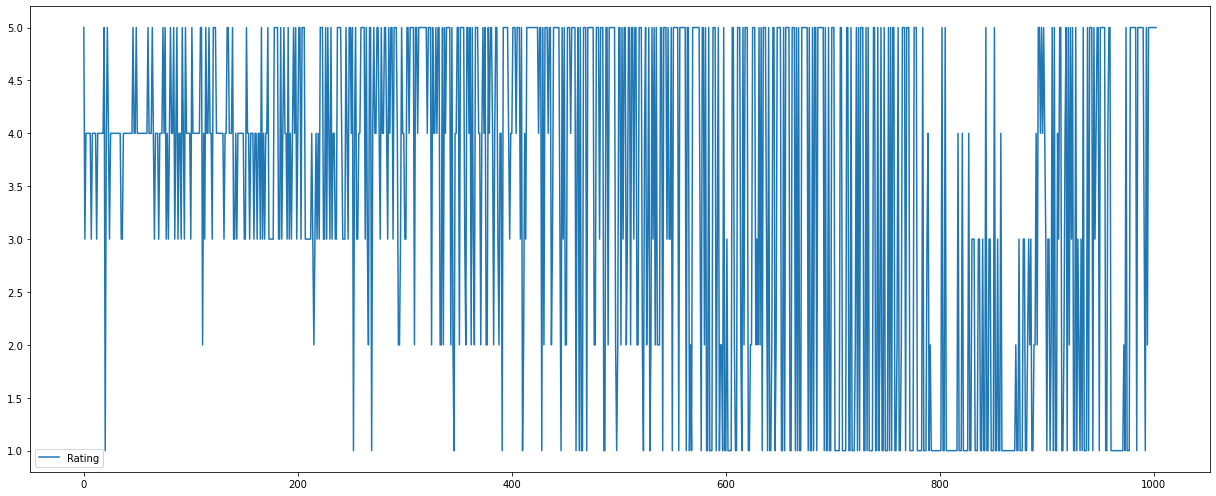

In [ ]:
plt.rcParams["figure.figsize"] = [17, 7]
plt.rcParams["figure.autolayout"] = True
columns = ["Date", "Rating"]
df2.plot()
#plt.show()

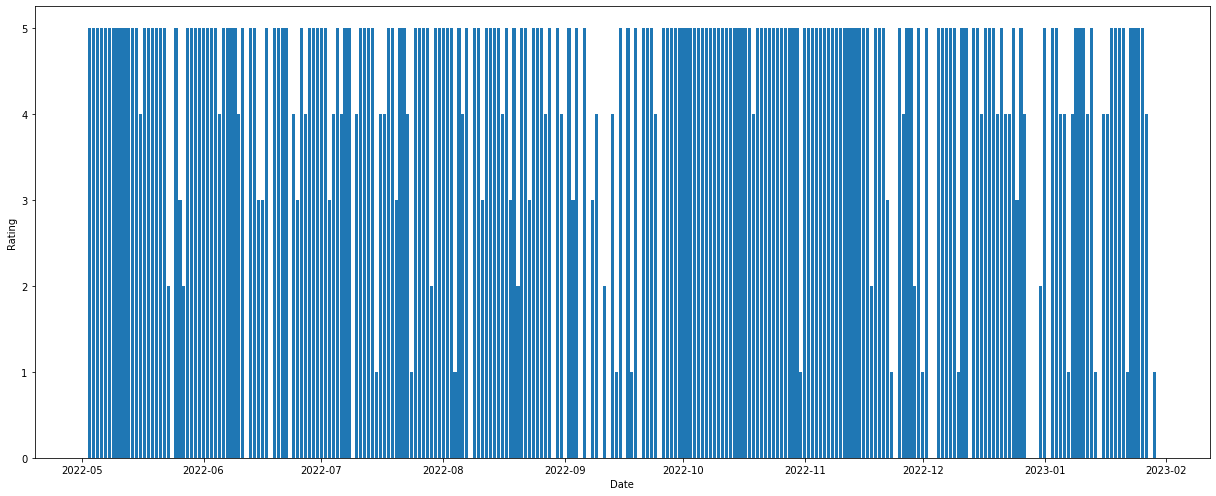

In [ ]:
fig, ax = plt.subplots()

plt.xlabel('Date')
plt.ylabel('Rating')

ax.bar(df2['Date'], df2['Rating'])

plt.show()

In [ ]:
#display(df2.to_string())

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df2)

            Date  Rating
0     2022-08-19     5.0
1     2022-06-06     3.0
2     2022-12-05     4.0
3     2023-01-16     4.0
4     2023-01-20     4.0
5     2023-01-17     4.0
6     2022-12-16     4.0
7     2022-10-10     3.0
8     2022-12-23     4.0
9     2023-01-27     4.0
10    2023-01-05     4.0
11    2023-01-12     4.0
12    2022-11-08     3.0
13    2022-12-27     4.0
14    2022-10-08     4.0
15    2022-11-02     4.0
16    2023-01-08     4.0
17    2023-01-06     4.0
18    2023-01-04     4.0
19    2022-05-08     5.0
20    2022-05-10     1.0
21    2022-10-22     4.0
22    2023-01-25     5.0
23    2023-01-06     4.0
24    2023-01-21     3.0
25    2022-11-03     4.0
26    2022-12-20     4.0
27    2022-10-13     4.0
28    2022-12-26     4.0
29    2022-12-22     4.0
30    2022-12-23     4.0
31    2022-12-21     4.0
32    2022-12-11     4.0
33    2022-11-28     4.0
34    2022-10-23     4.0
35    2022-10-06     3.0
36    2022-10-27     3.0
37    2022-12-08     4.0
38    2022-11-30     4.0


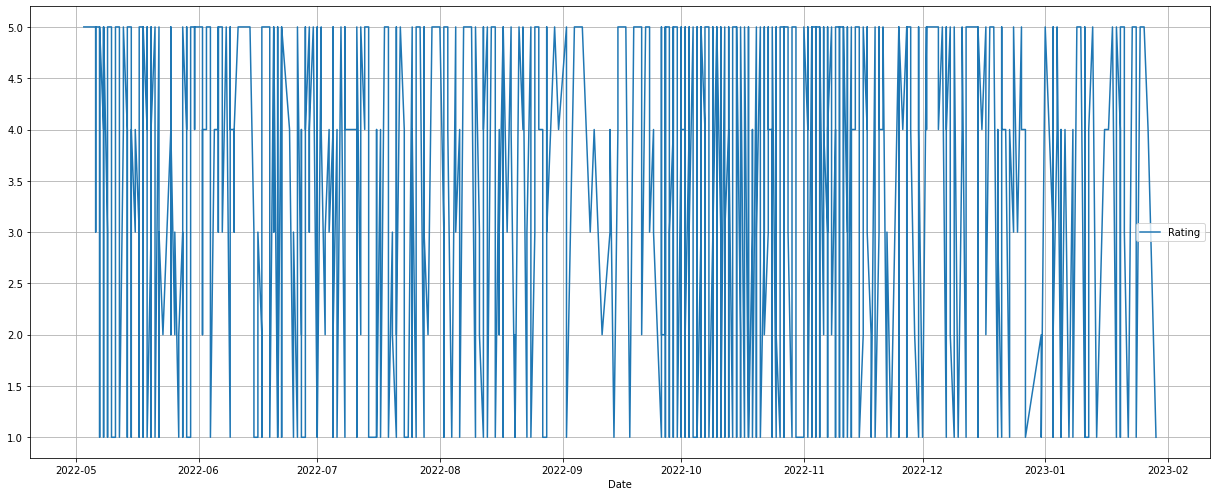

In [ ]:
df2 = df2.set_index("Date")
df2.plot(grid = True)

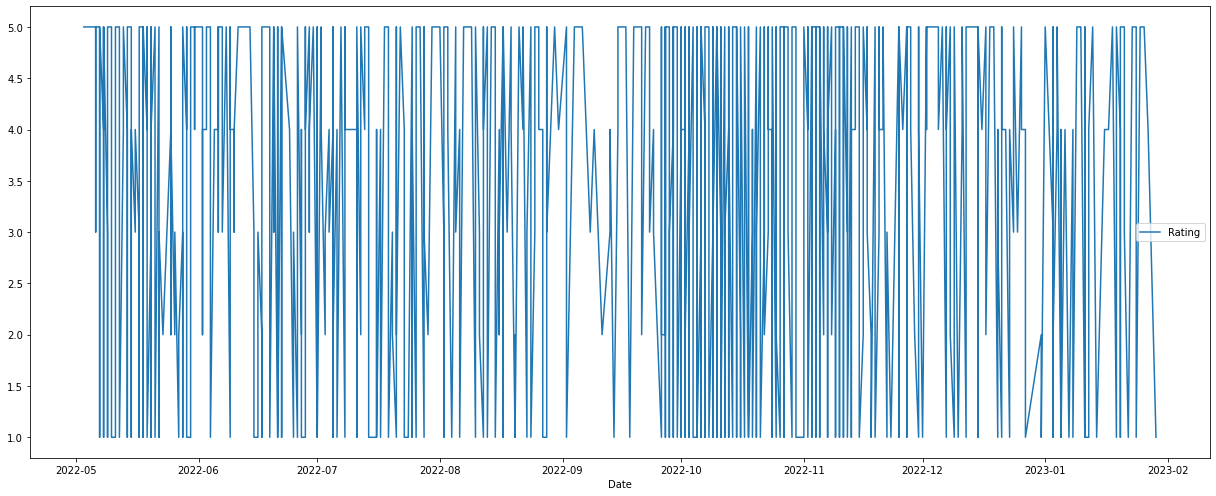

In [ ]:
df2.set_index('Date').plot()

In [ ]:
print(type(df2["Date"][0]))

<class 'datetime.date'>


In [ ]:
df2['Date'] = pd.to_datetime(df2.Date, format='%Y-%m-%d')

In [ ]:
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
df2['year'] = df2.Date.dt.year
df2['date'] = df2.Date.dt.strftime('%m-%d')
'''with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df2)'''
unstacked = df2.set_index(['year', 'date'], append=True).Rating.unstack(-2)
unstacked.head()

           Date  Rating  Year   date  year
0    2022-08-19     5.0  2022  08-19  2022
1    2022-06-06     3.0  2022  06-06  2022
2    2022-12-05     4.0  2022  12-05  2022
3    2023-01-16     4.0  2023  01-16  2023
4    2023-01-20     4.0  2023  01-20  2023
5    2023-01-17     4.0  2023  01-17  2023
6    2022-12-16     4.0  2022  12-16  2022
7    2022-10-10     3.0  2022  10-10  2022
8    2022-12-23     4.0  2022  12-23  2022
9    2023-01-27     4.0  2023  01-27  2023
10   2023-01-05     4.0  2023  01-05  2023
11   2023-01-12     4.0  2023  01-12  2023
12   2022-11-08     3.0  2022  11-08  2022
13   2022-12-27     4.0  2022  12-27  2022
14   2022-10-08     4.0  2022  10-08  2022
15   2022-11-02     4.0  2022  11-02  2022
16   2023-01-08     4.0  2023  01-08  2023
17   2023-01-06     4.0  2023  01-06  2023
18   2023-01-04     4.0  2023  01-04  2023
19   2022-05-08     5.0  2022  05-08  2022
20   2022-05-10     1.0  2022  05-10  2022
21   2022-10-22     4.0  2022  10-22  2022
22   2023-0

,year,2022,2023
,date,,
0,08-19,5.0,NaN
1,06-06,3.0,NaN
2,12-05,4.0,NaN
3,01-16,NaN,4.0
4,01-20,NaN,4.0


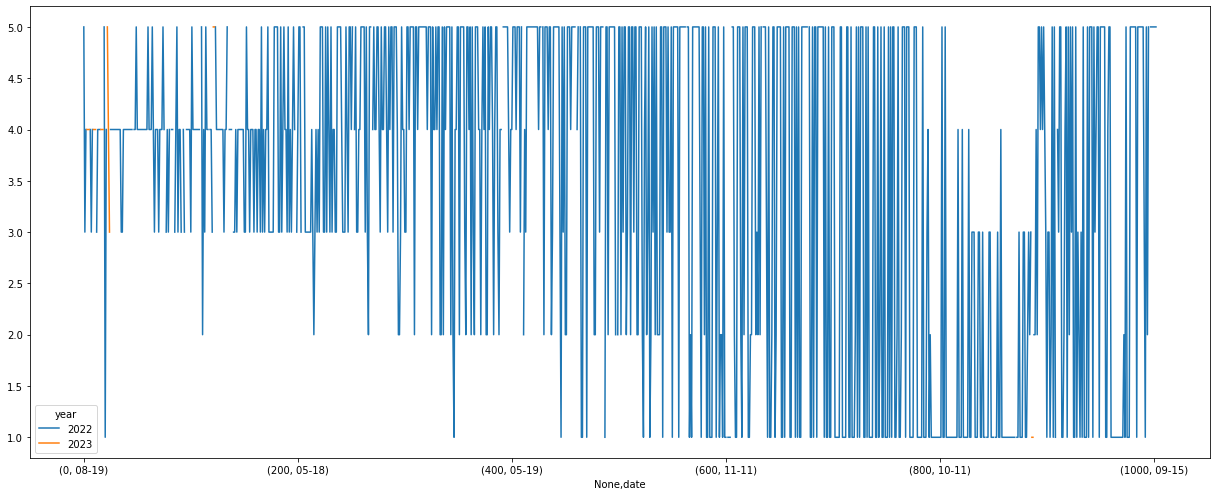

In [ ]:
unstacked.plot()

In [ ]:
df2['Year'] = df2['Date'].dt.strftime('%Y')
df2['date'] = df2.Date.dt.strftime('%m-%d')

In [ ]:
df2

,Date,Rating,Year,date,year
0,2022-08-19,5.0,2022,08-19,2022
1,2022-06-06,3.0,2022,06-06,2022
2,2022-12-05,4.0,2022,12-05,2022
3,2023-01-16,4.0,2023,01-16,2023
4,2023-01-20,4.0,2023,01-20,2023
...,...,...,...,...,...
998,2022-10-04,5.0,2022,10-04,2022
999,2022-08-28,5.0,2022,08-28,2022
1000,2022-09-15,5.0,2022,09-15,2022
1001,2022-10-08,5.0,2022,10-08,2022


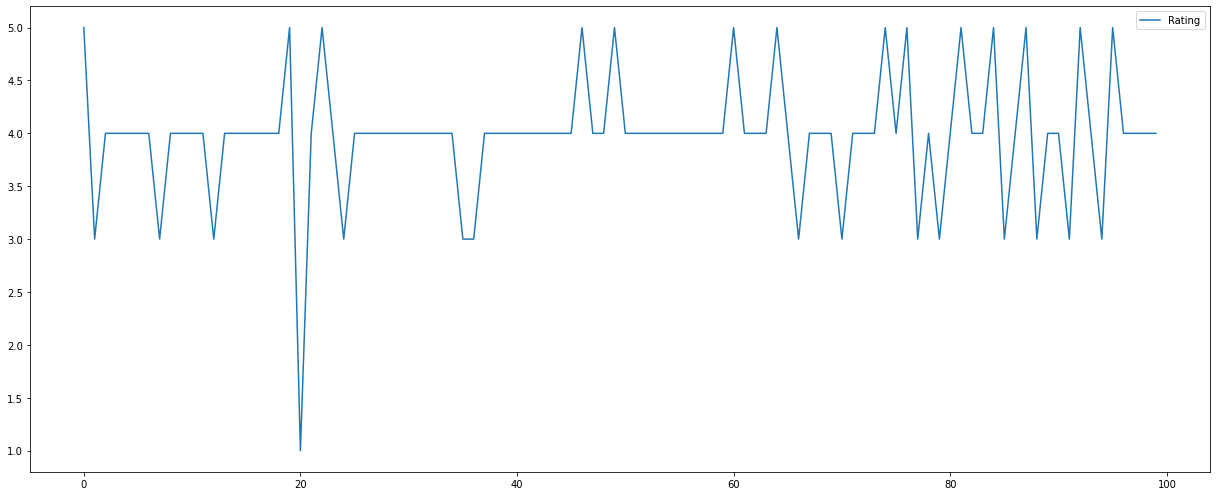

In [ ]:
df3 = df2[0:100]
df3.plot()

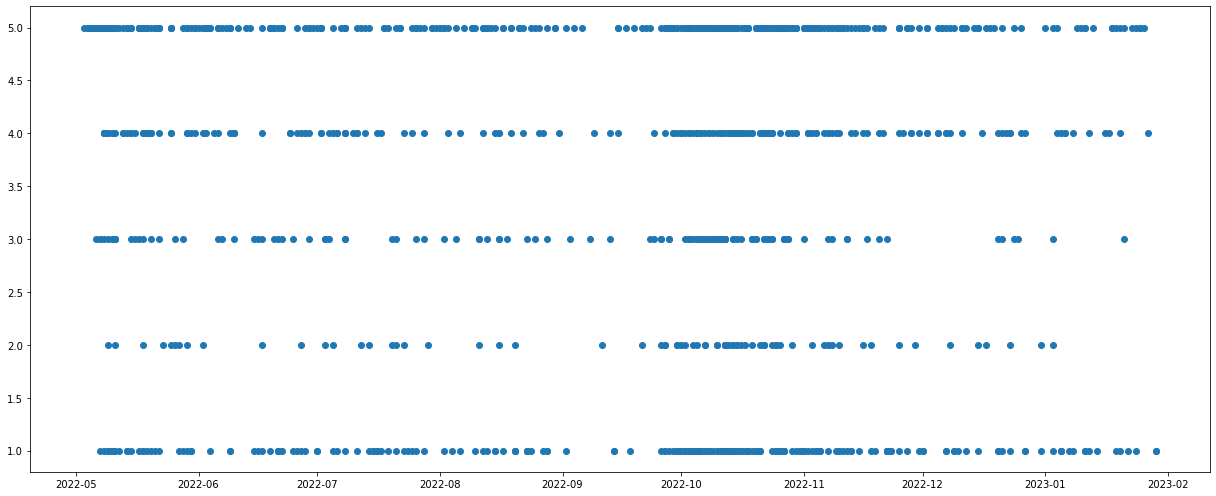

In [ ]:
plt.scatter(df2.Date, df2.Rating)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
df2 = pd.DataFrame().assign(Date = df["Date of Review"], Rating = df["Rating(Out of 5)"])
i = 0
for date in df2["Date"]:
    df2["Date"][i] = get_date(date)
    i = i + 1
# Sort values..
df2.sort_values(by="Date", ascending = True, inplace = True) 
# Backup..
df3 = df2
df2

<ipython-input-32-1c4d9a6a6347>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Date"][i] = get_date(date)


,Date,Rating
805,2022-05-03,5.0
110,2022-05-04,5.0
731,2022-05-04,5.0
317,2022-05-04,5.0
342,2022-05-05,5.0
...,...,...
22,2023-01-25,5.0
76,2023-01-26,5.0
9,2023-01-27,4.0
886,2023-01-29,1.0


In [33]:
df2['Date'] = pd.to_datetime(df2.Date, format='%Y-%m-%d')
#df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2['Month'] = df2['Date'].dt.strftime('%m-%Y')
df2

,Date,Rating,Month
805,2022-05-03,5.0,05-2022
110,2022-05-04,5.0,05-2022
731,2022-05-04,5.0,05-2022
317,2022-05-04,5.0,05-2022
342,2022-05-05,5.0,05-2022
...,...,...,...
22,2023-01-25,5.0,01-2023
76,2023-01-26,5.0,01-2023
9,2023-01-27,4.0,01-2023
886,2023-01-29,1.0,01-2023


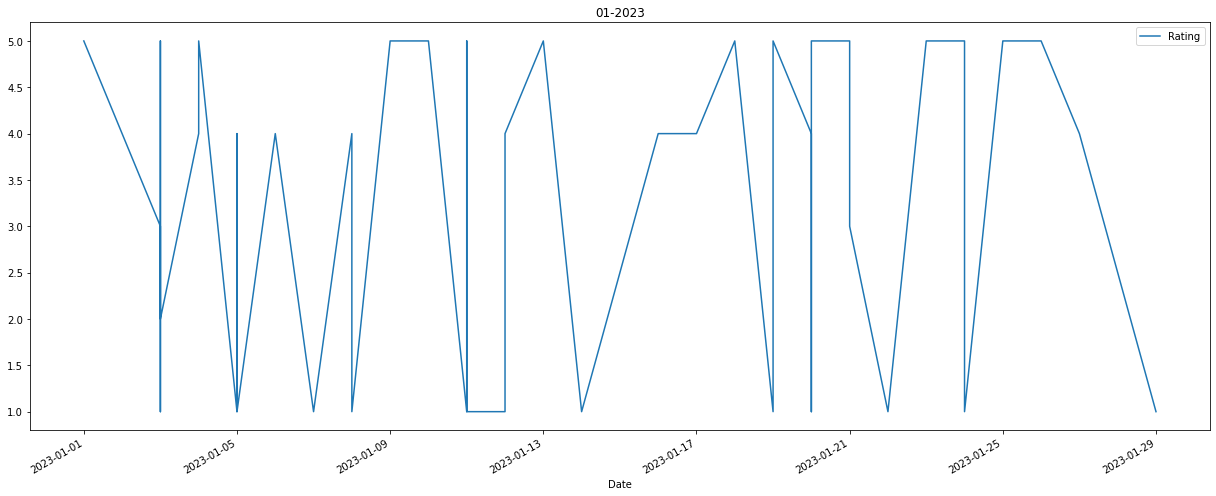

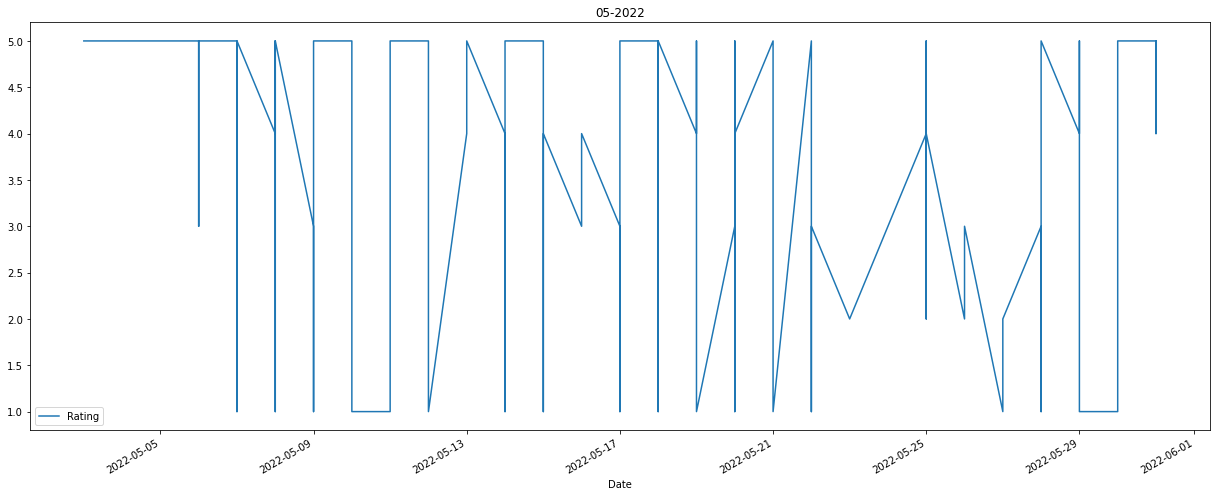

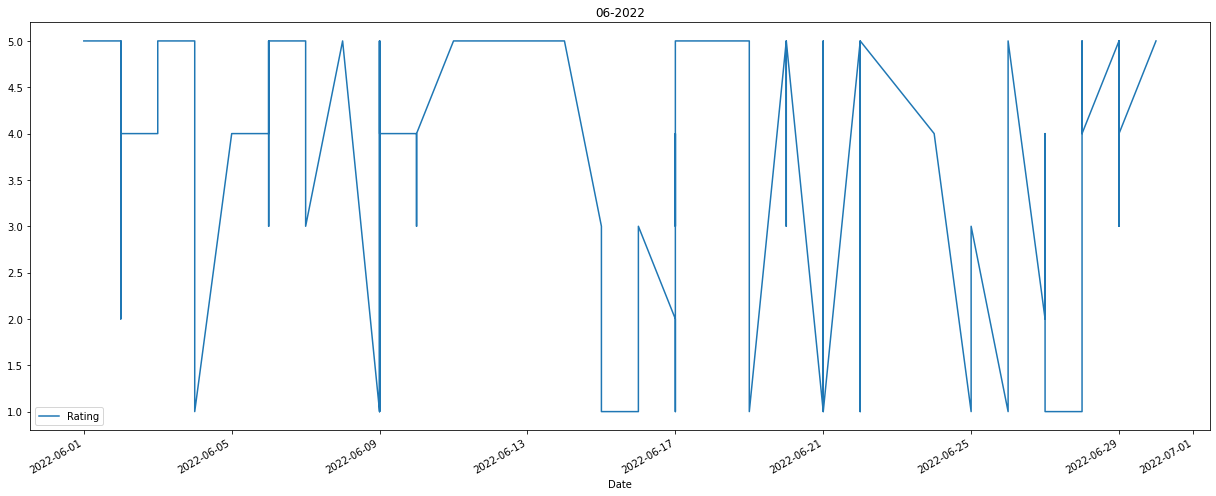

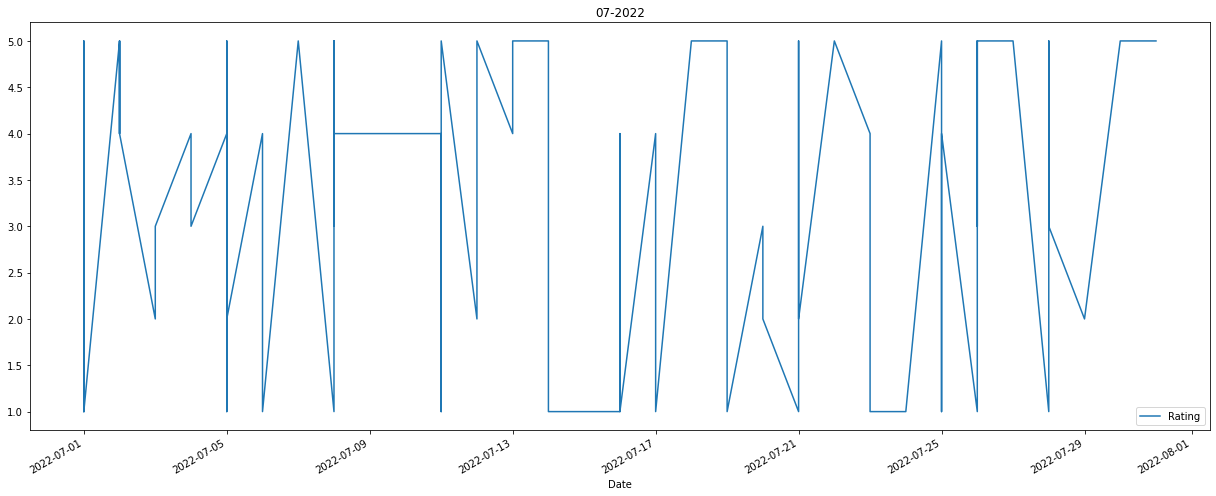

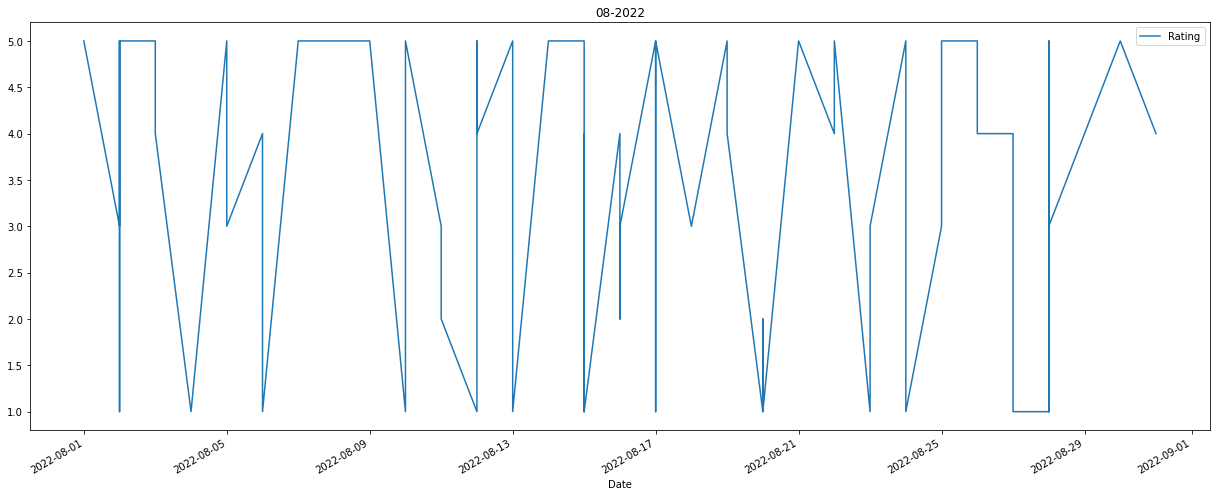

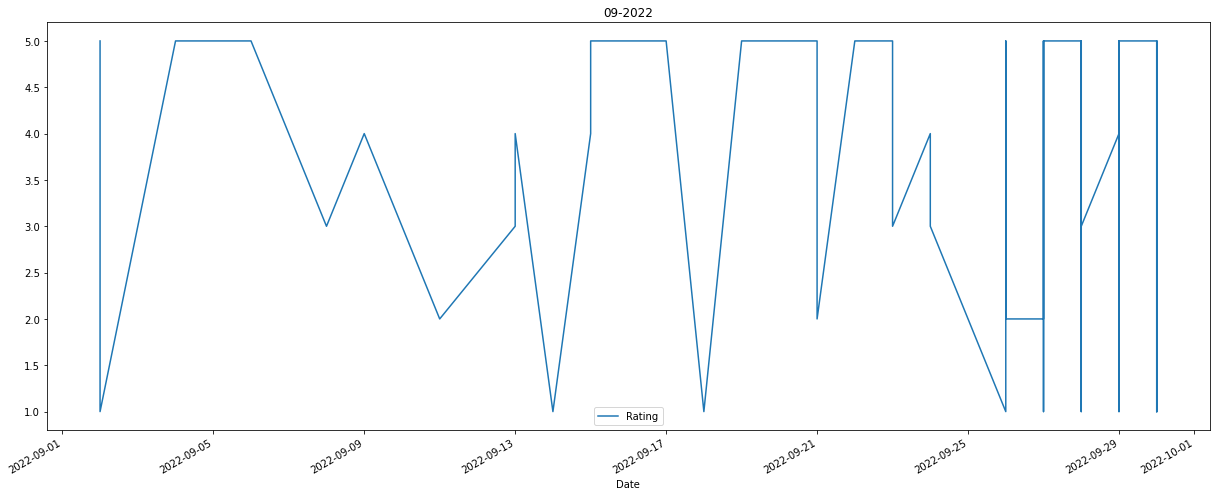

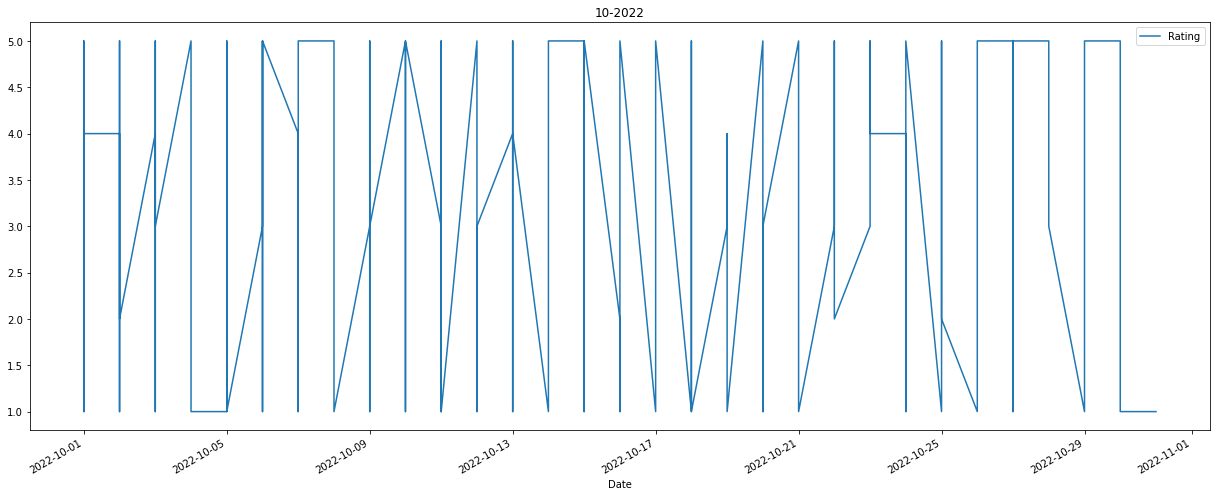

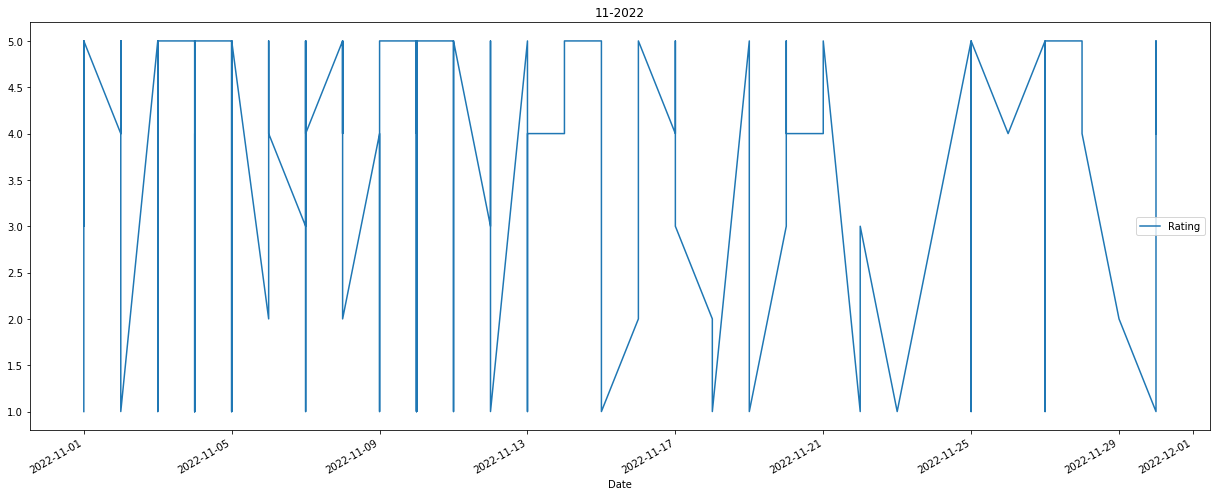

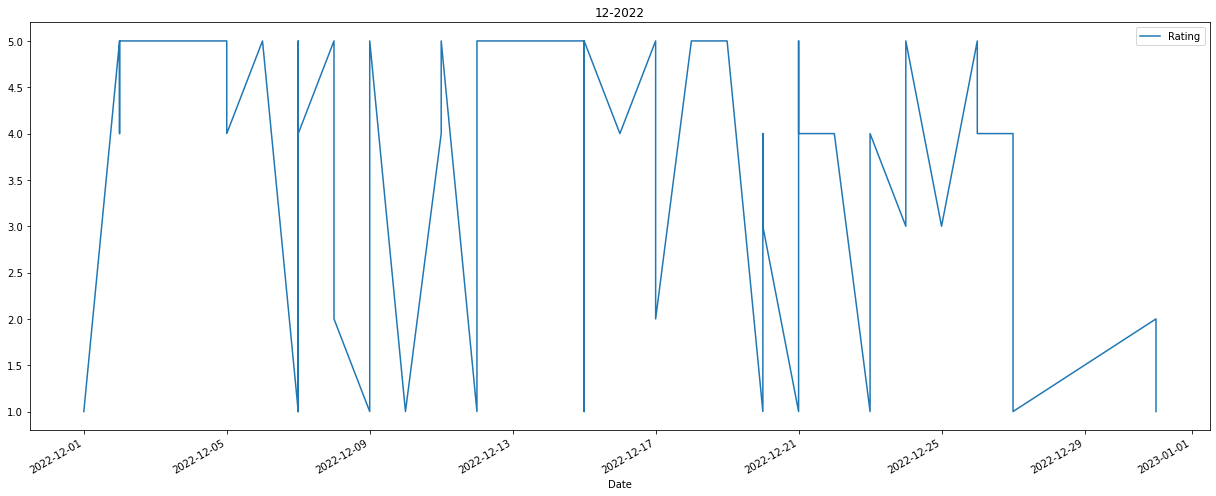

In [34]:
grouped = df2.groupby(['Month'])
for key, group in grouped:
    group.set_index('Date')[['Rating']].plot(title = key)

In [194]:
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired
colorst = [colormap(i + 0.12) for i in np.linspace(0, 0.9, 12)]
print(colorst)
random.shuffle(colorst)
print(colorst)
#df2.Month.unique()

[(0.0, 0.1658868973471741, 1.0, 1.0), (0.0, 0.930796862745098, 1.0, 1.0), (0.0, 0.9853012265331665, 0.4094620992709478, 1.0), (0.3496637770897833, 0.8227525720876585, 0.0, 1.0), (0.6075162487945996, 1.0, 0.12490198079231678, 1.0), (0.9823046340940748, 0.9807338262080787, 0.015486814725890363, 1.0), (1.0, 0.7776265723775846, 0.0337631833910035, 1.0), (1.0, 0.24242629051620673, 0.0, 1.0), (1.0, 0.0, 0.6947963355834142, 1.0), (0.6912889749219927, 0.2682950819672131, 0.9811260366441659, 1.0), (0.9542314878892734, 0.700008650519031, 0.9603445213379469, 1.0), (0.9961, 0.9725, 0.9961, 1.0)]
[(0.9823046340940748, 0.9807338262080787, 0.015486814725890363, 1.0), (0.9961, 0.9725, 0.9961, 1.0), (0.0, 0.9853012265331665, 0.4094620992709478, 1.0), (1.0, 0.0, 0.6947963355834142, 1.0), (0.9542314878892734, 0.700008650519031, 0.9603445213379469, 1.0), (0.6075162487945996, 1.0, 0.12490198079231678, 1.0), (0.0, 0.1658868973471741, 1.0, 1.0), (1.0, 0.7776265723775846, 0.0337631833910035, 1.0), (0.69128897

In [ ]:
colormap = plt.cm.gist_ncar
for i in np.linspace(0, 0.9, 12):
    print(f"Index : {i} \tMap : {colormap(i)}")
#np.linspace(0, 0.9, 12)

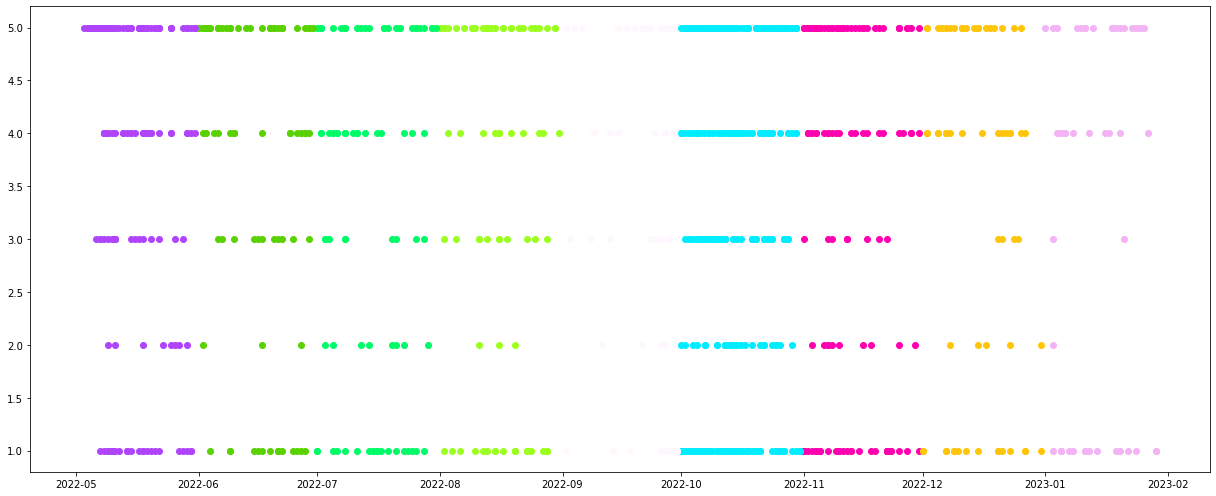

In [ ]:
%%capture --no-display
labels = range(1, len(df2.Rating) + 1)
cdict = {
    1: 'red',
    2: 'orange',
    3: 'yellow',
    4: 'blue',
    5: 'green'
    }
fig = plt.figure()
warnings.filterwarnings('ignore')
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
ax = fig.add_subplot(111)
print("--------------------------------------------------------")
warnings.filterwarnings('ignore')
for x, y, m, lab in zip(df2.Date, df2.Rating, df2.Month, labels):
        warnings.filterwarnings('ignore')
        print("Date  : ", x, "  |  ", y, "  |  ", m, "  |  ", lab, "  |  ", colorst[int(m) - 1])
        ax.scatter(x, y, c = colorst[int(m) - 1], label = lab)
        warnings.filterwarnings('ignore')
print(colorst)

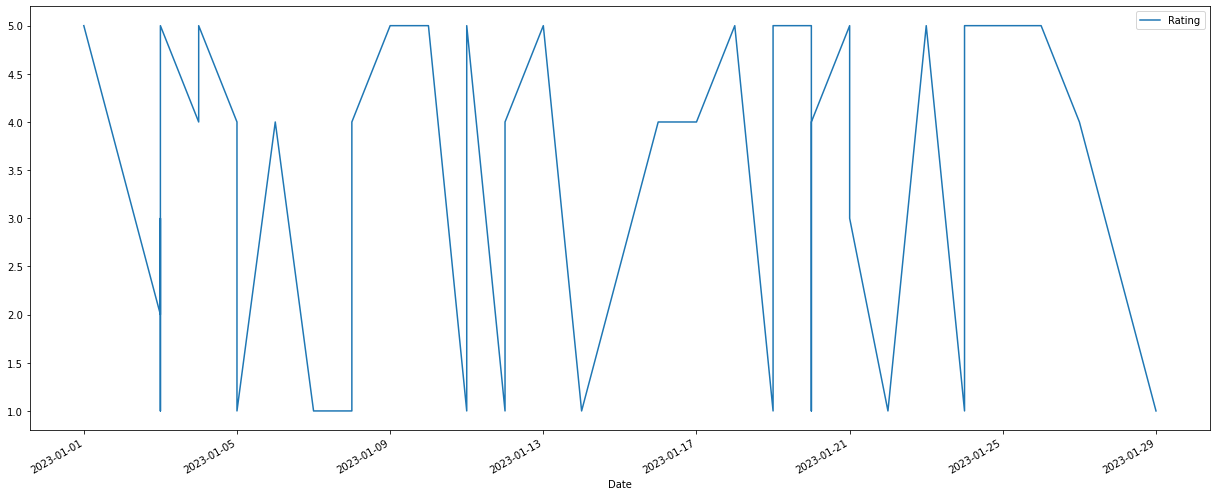

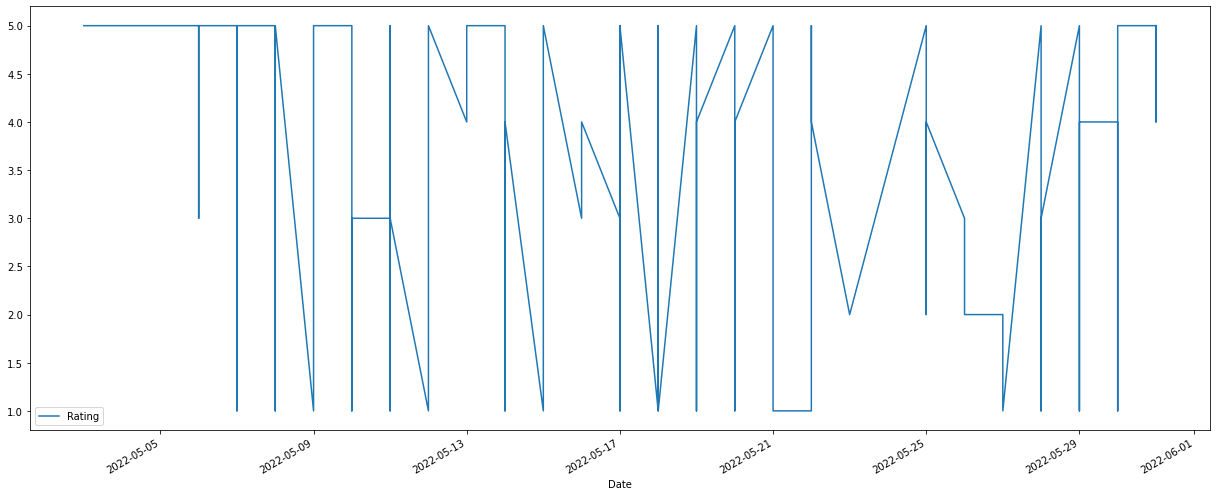

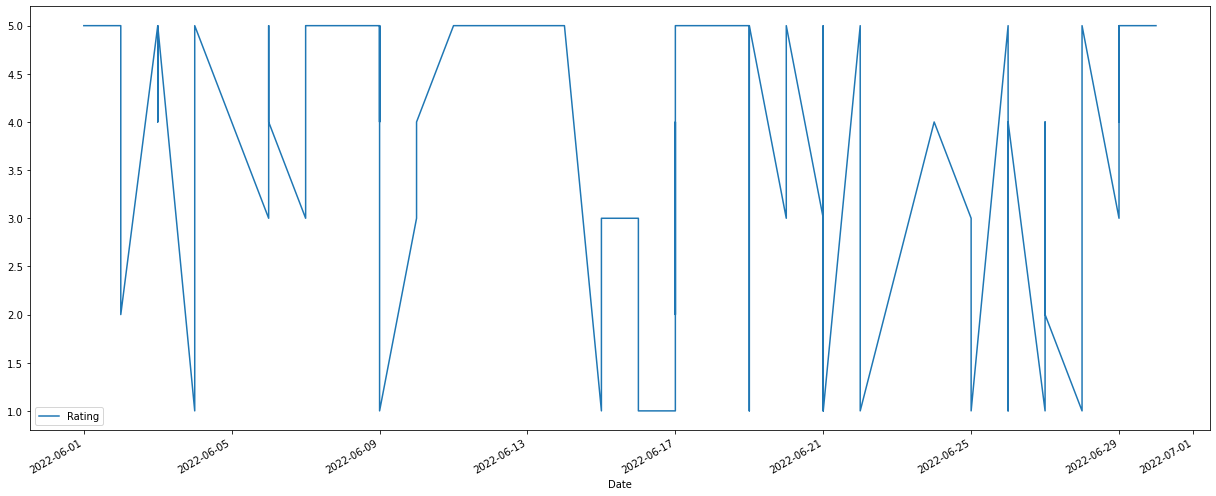

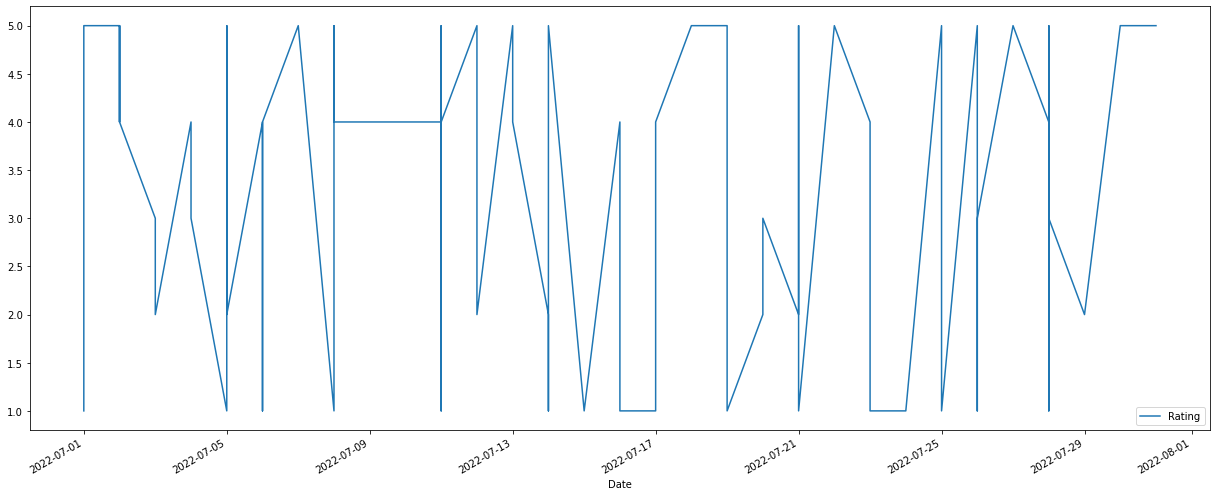

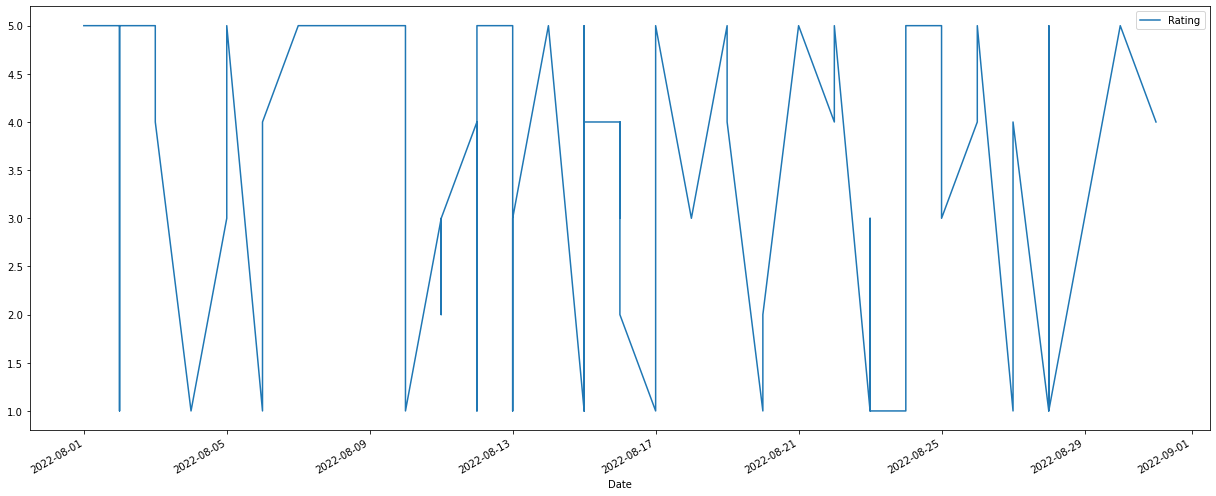

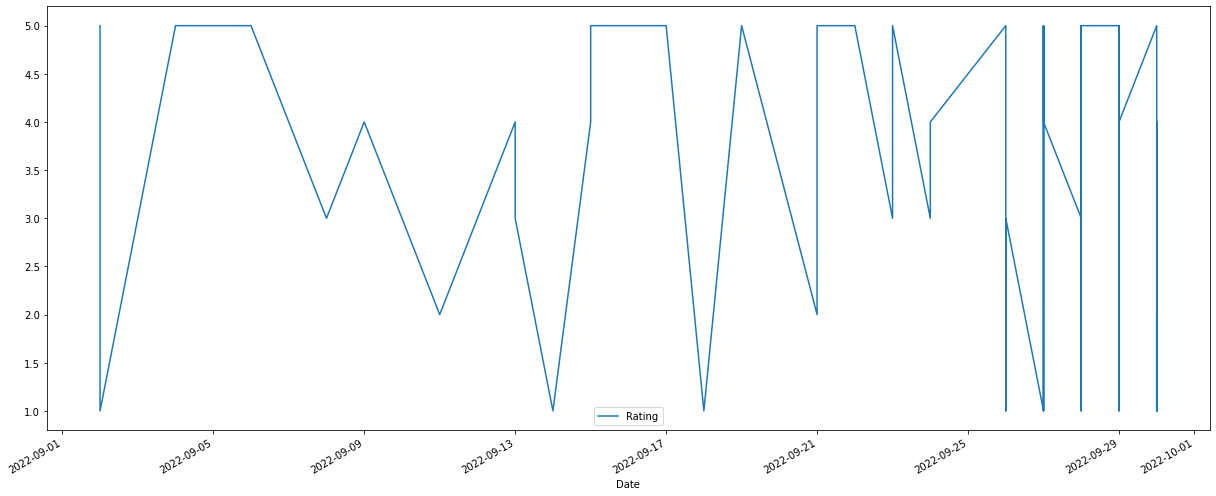

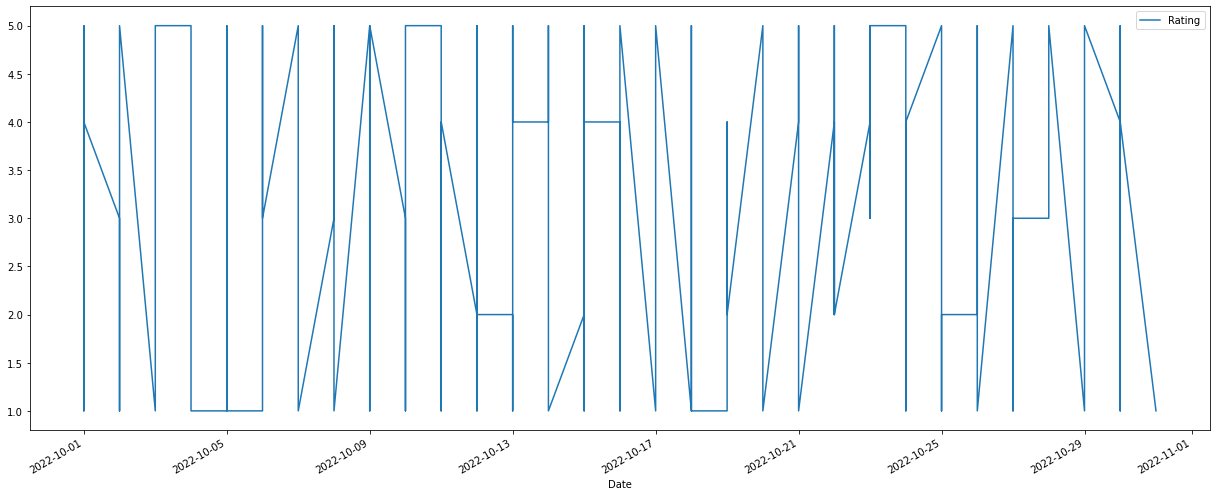

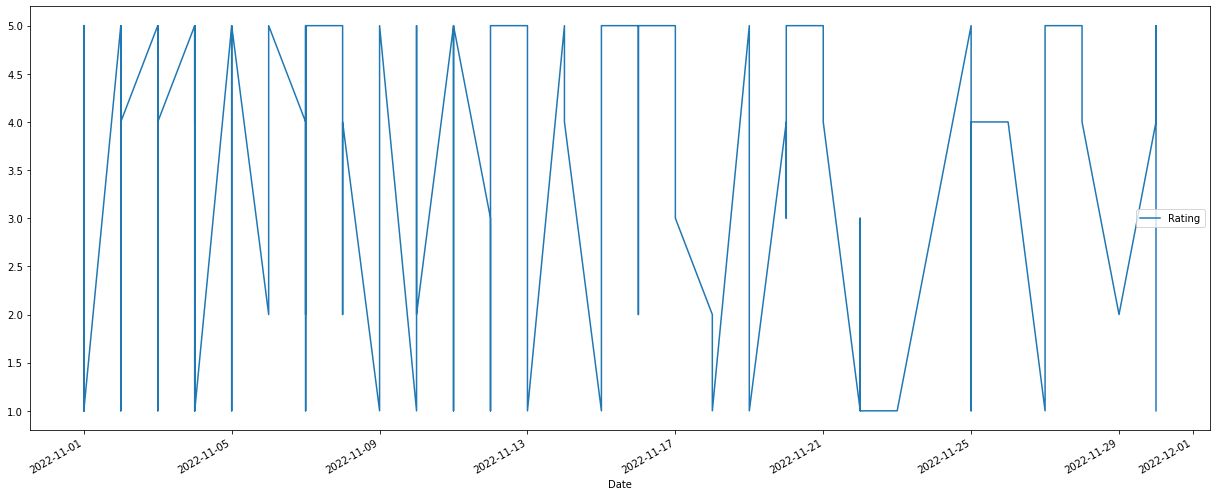

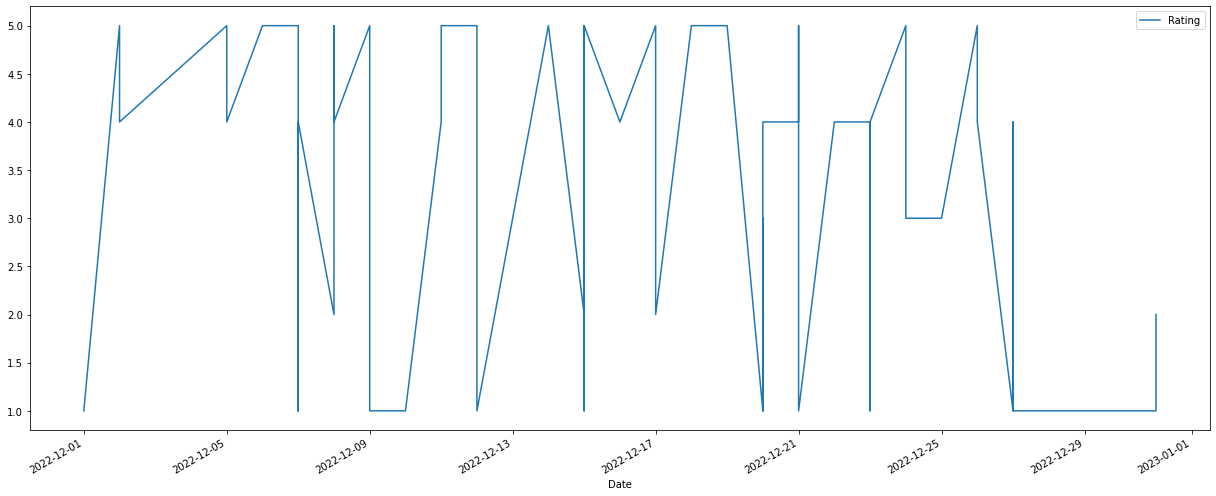

In [199]:
#labels = range(1, len(df2.Rating) + 1)
'''fig = plt.figure()
ax = fig.add_subplot(111)
for x, y, m, lab in zip(df2.Date, df2.Rating, df2.Month, labels):
        print("Date  : ", x, "  |  ", y, "  |  ", m, "  |  ", lab, "  |  ", colorst[int(m) - 1])
        ax.scatter(x, y, c = colorst[int(m) - 1], label = lab)'''
#df2 = df2.set_index("Date")
#df2.plot(grid = True)
df3 = df2.sort_values(by=['Month'], ascending=True)
for i in df3.Month.unique():
    #df2.plot(c = colorst[int(i) - 1], grid = True)
    df_temp = df3[df3["Month"] == i]
    df_temp.plot(x = "Date", y = "Rating")

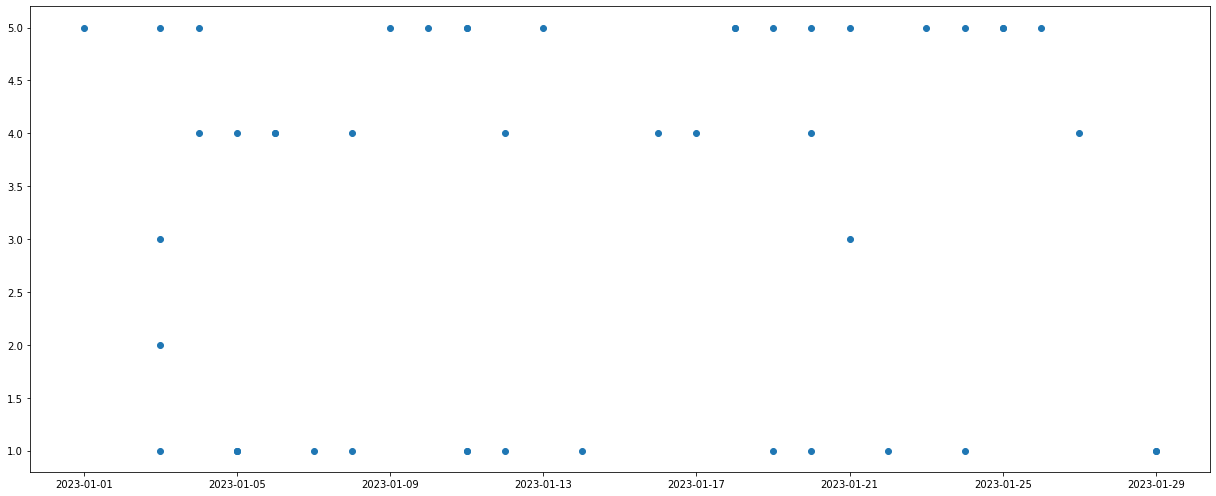

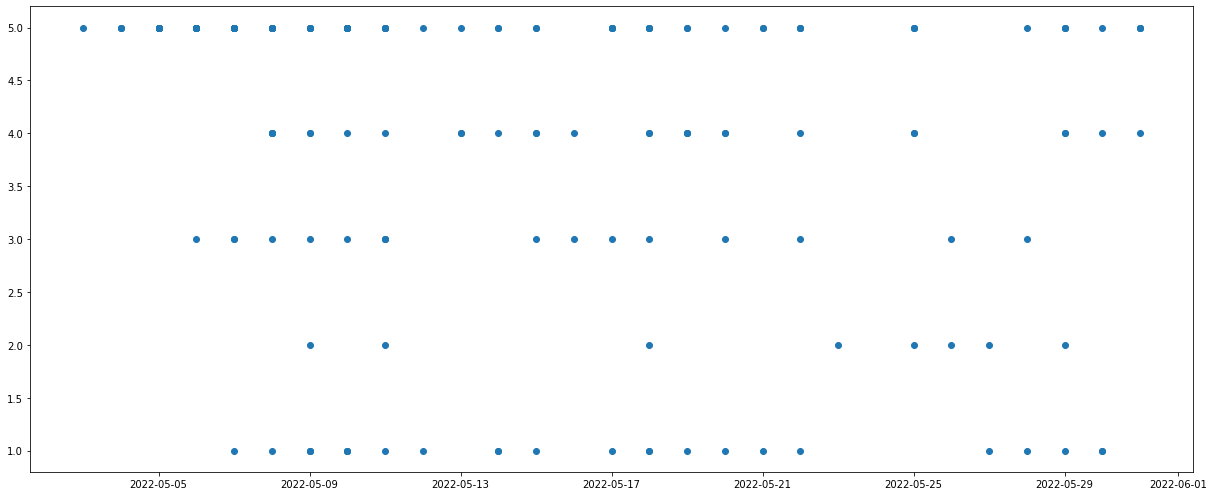

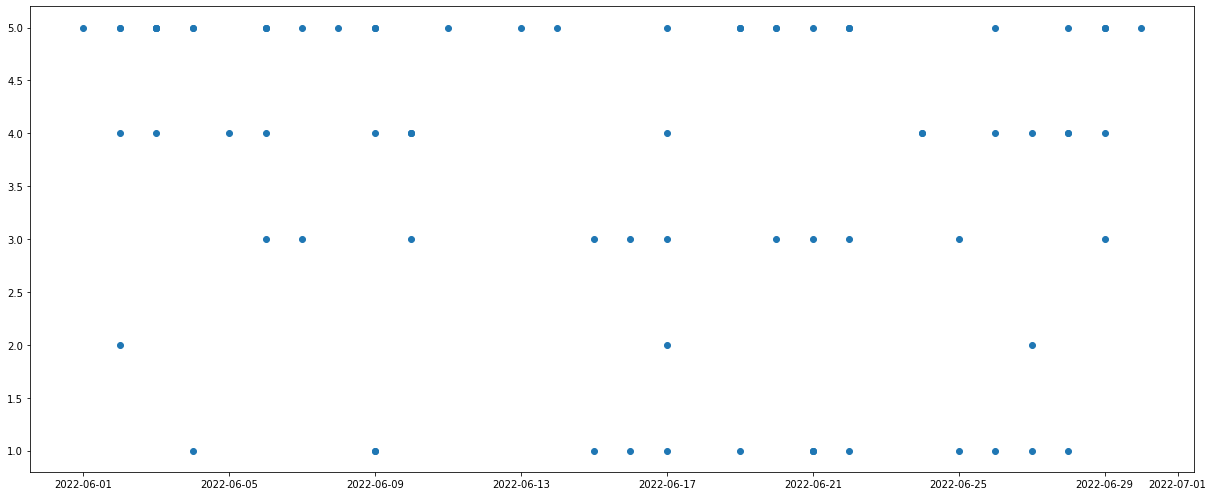

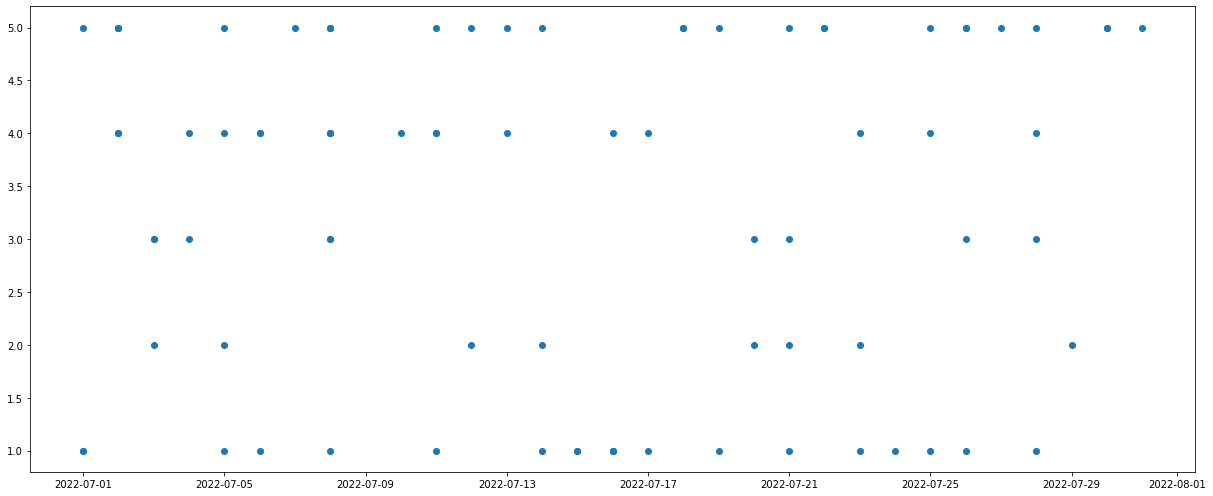

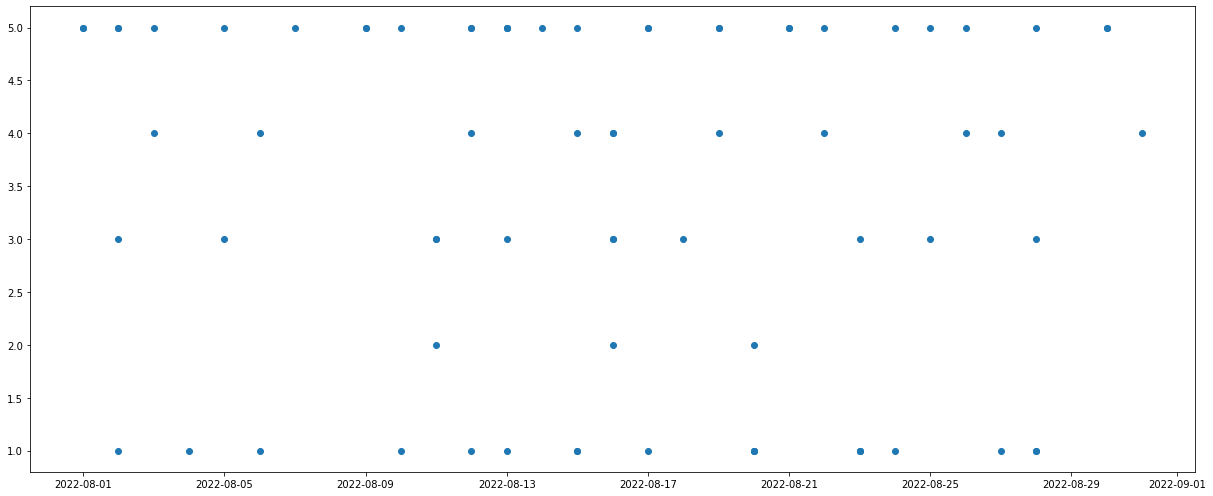

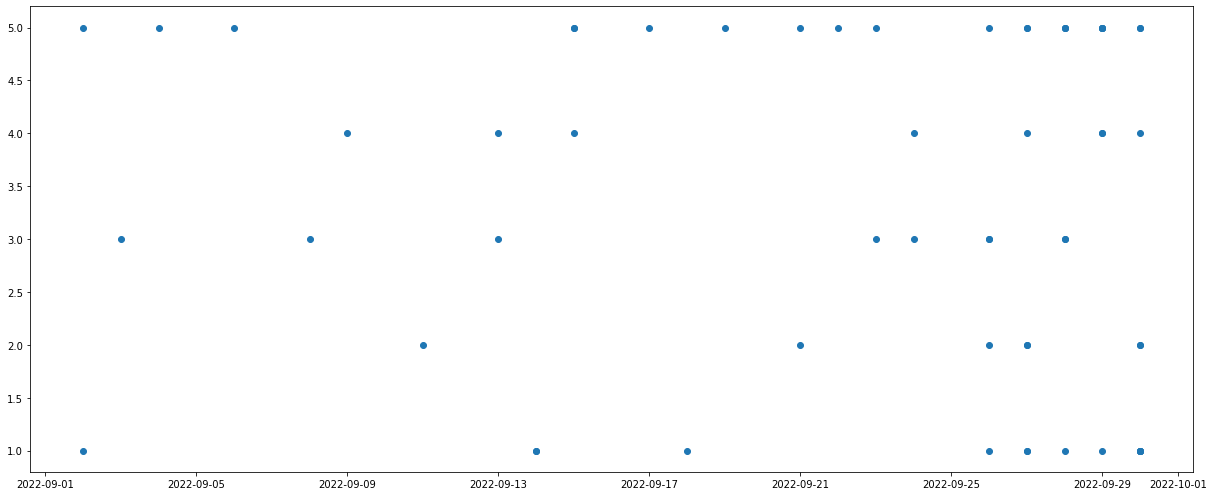

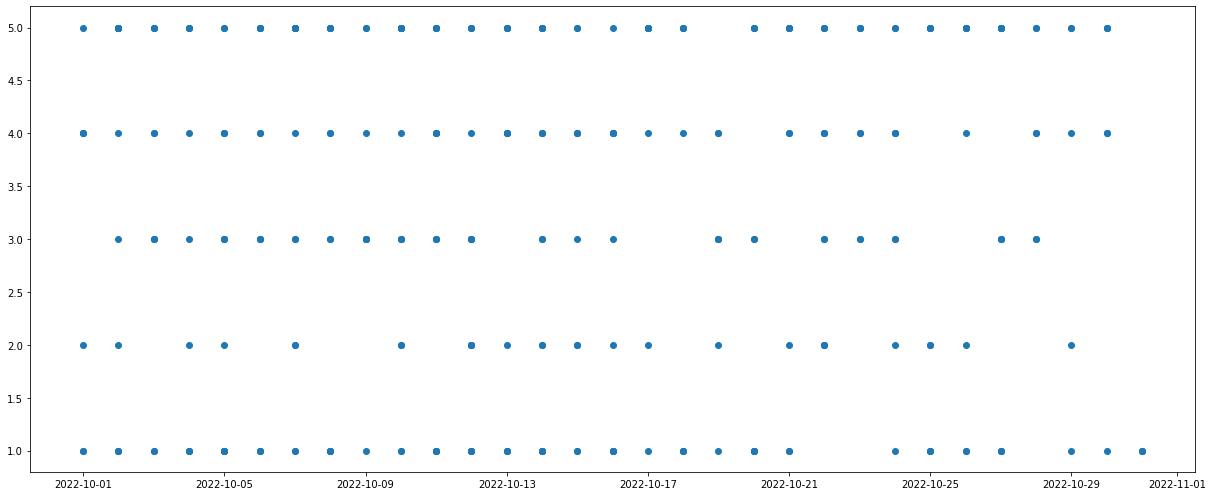

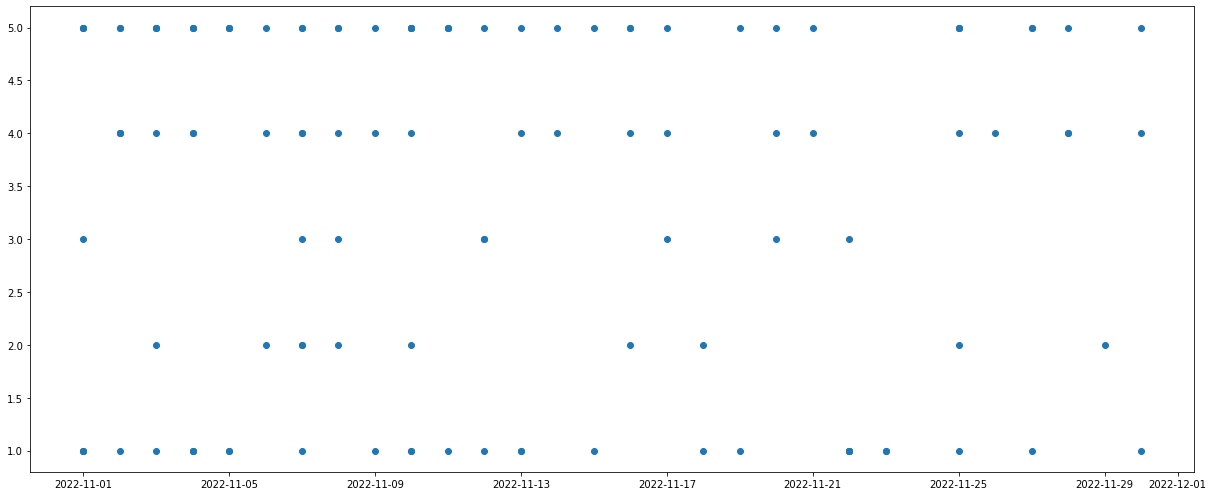

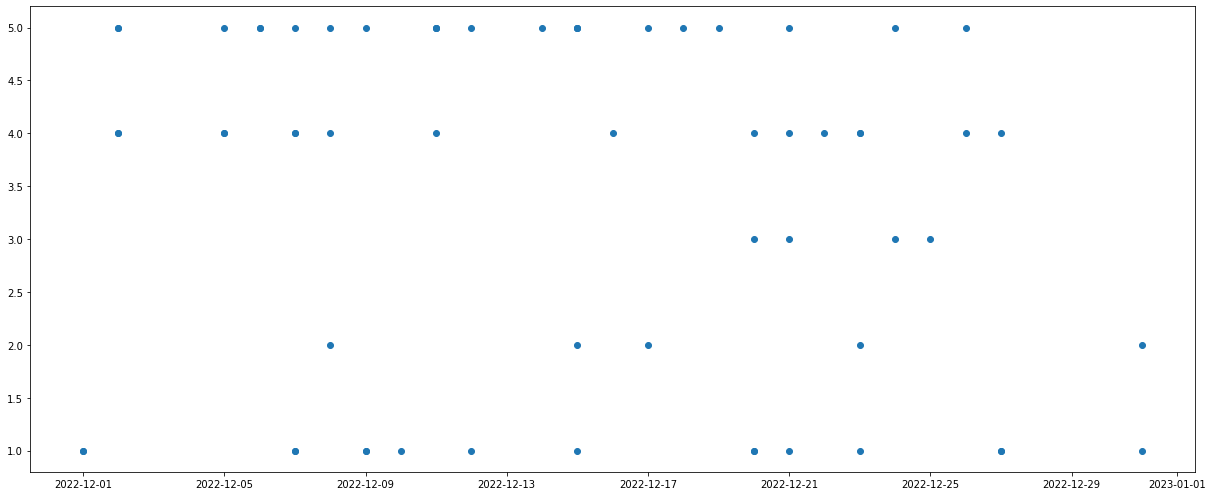

In [201]:
df3 = df2.sort_values(by=['Month'], ascending=True)
for i in df3.Month.unique():
    #df2.plot(c = colorst[int(i) - 1], grid = True)
    df_temp = df3[df3["Month"] == i]
    #df_temp.plot(x = "Date", y = "Rating")
    plt.scatter(df_temp.Date, df_temp.Rating)
    plt.show()

In [208]:
bar_colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired
bar_colorst = [bar_colormap(i + 0.12) for i in np.linspace(0, 0.9, 5)]
bar_colorst

[(0.0, 0.1658868973471741, 1.0, 1.0),
 (0.22479277605779147, 0.8965318877354863, 0.0, 1.0),
 (1.0, 0.8840160862887958, 0.0, 1.0),
 (0.9732819172113288, 0.013357348125890886, 0.9868275515334339, 1.0),
 (0.9961, 0.9725, 0.9961, 1.0)]

In [ ]:
df3 = df2.sort_values(by=['Month'], ascending=True)
#df3["Date"] = df3["Date"].values.astype('int64')
df3["Date"]
for i in df3.Month.unique():
    #df2.plot(c = colorst[int(i) - 1], grid = True)
    df_temp = df3[df3["Month"] == i]
    #df_temp.plot(x = "Date", y = "Rating")
    #plt.bar(df_temp.Date, df_temp.Rating, color = bar_colorst)
    plotdata = df_temp
    plotdata.plot(kind='bar', stacked=True)
    plt.title("Month " + i)
    plt.xlabel("Date")
    plt.ylabel("Rating")
    #plt.show()
df3

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df3)

In [16]:
plt.rcParams["figure.figsize"] = [17, 7]
plt.rcParams["figure.autolayout"] = True

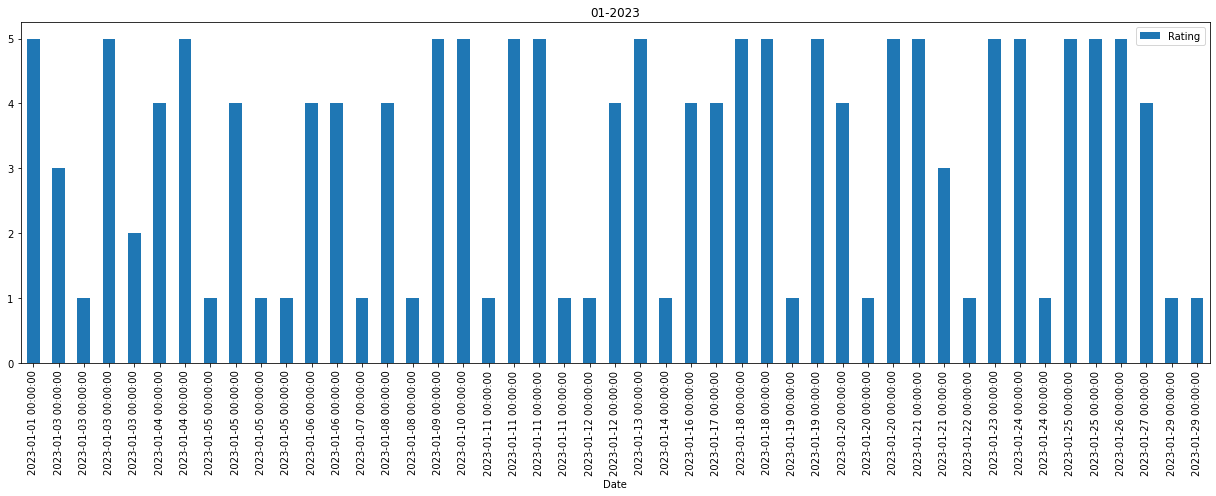

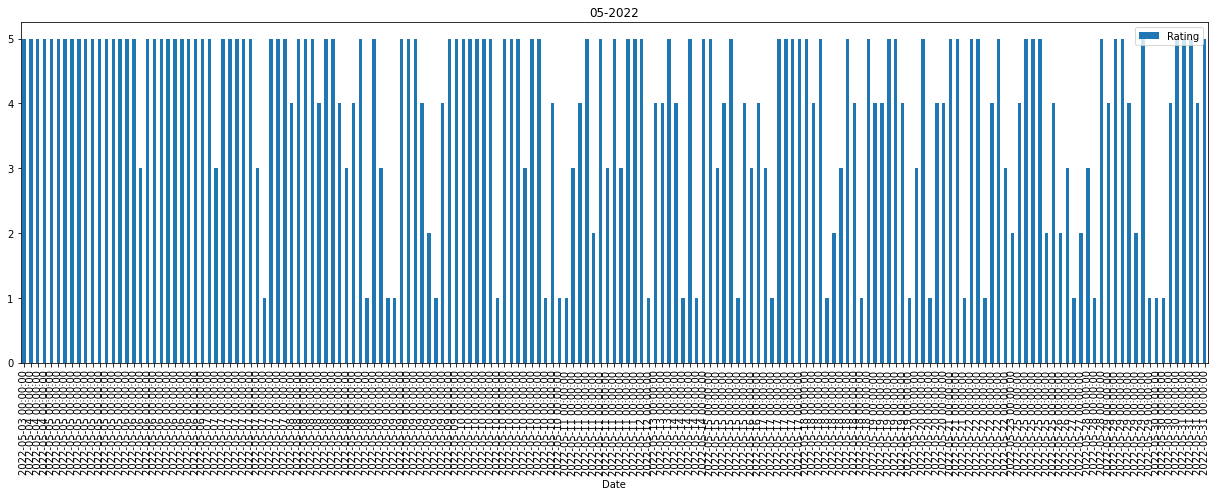

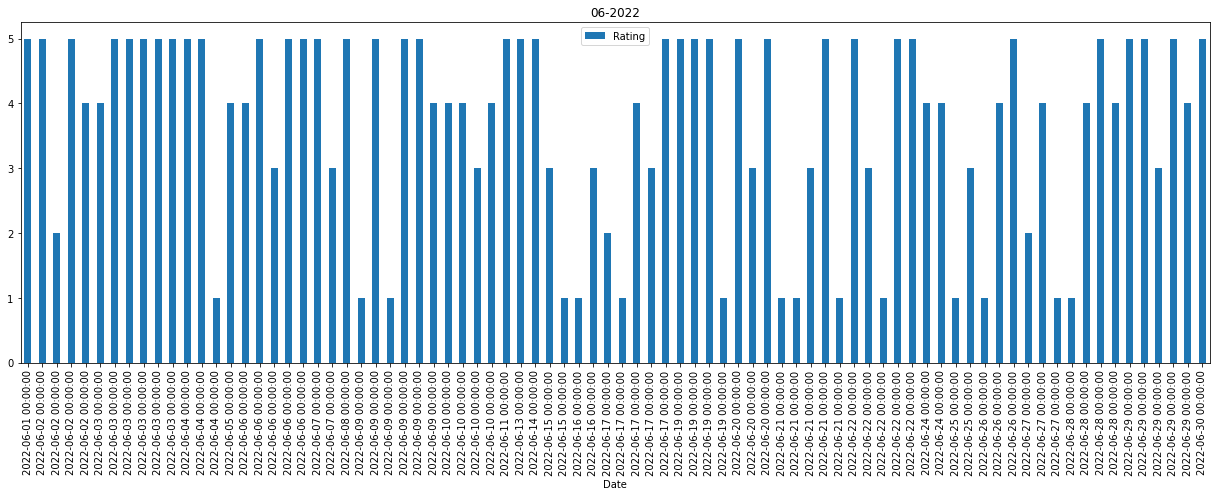

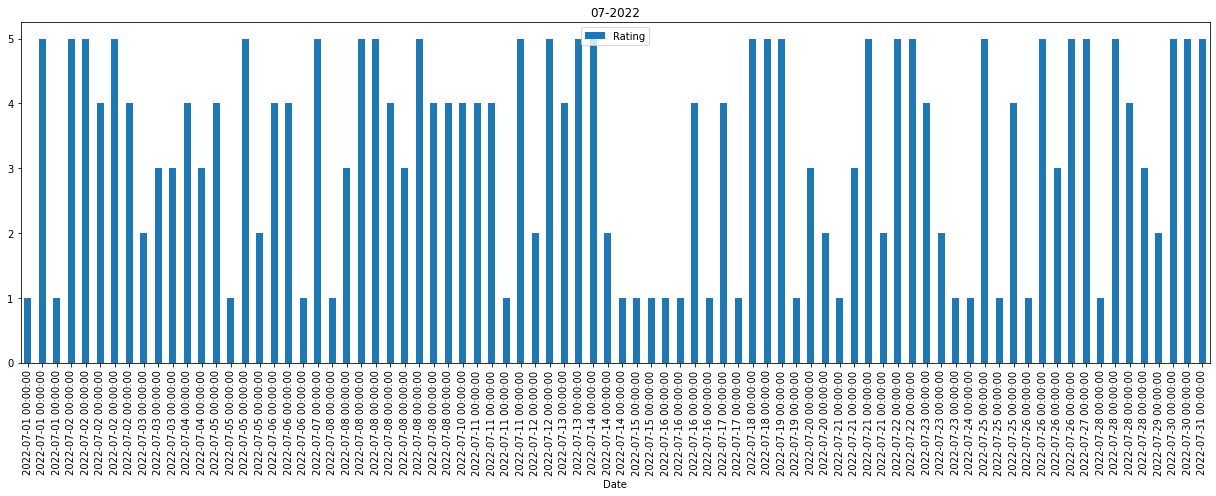

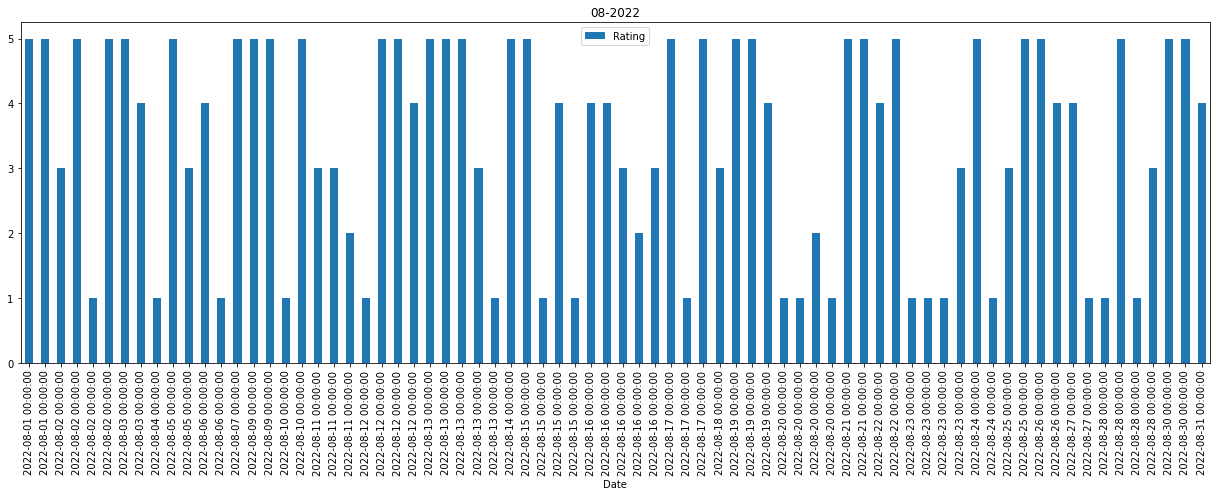

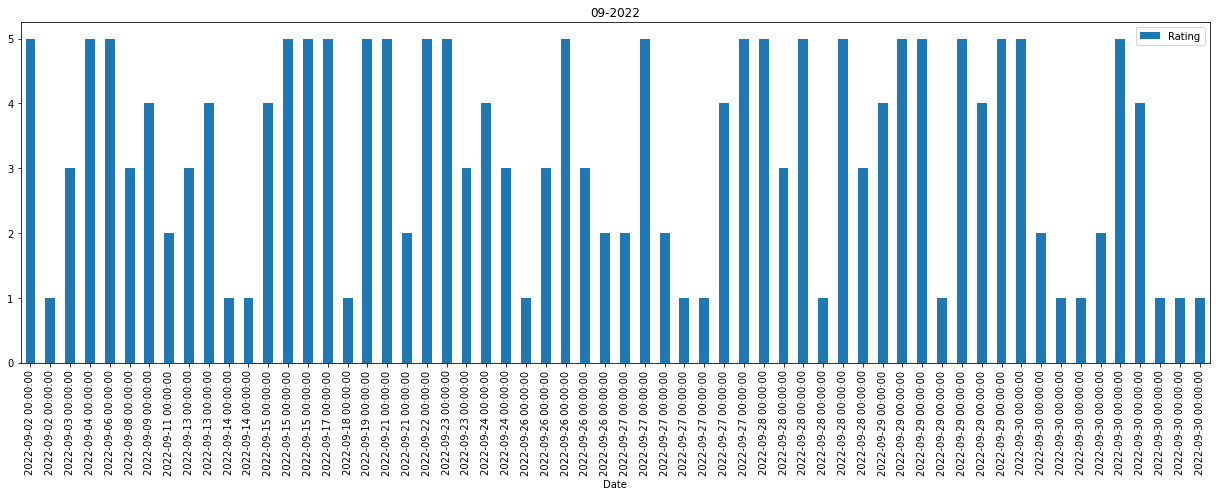

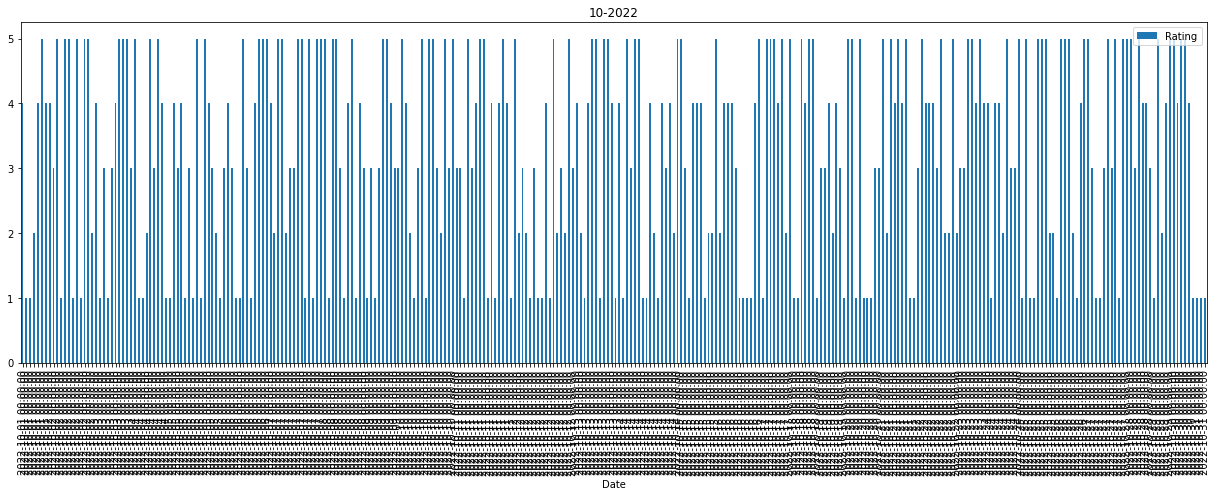

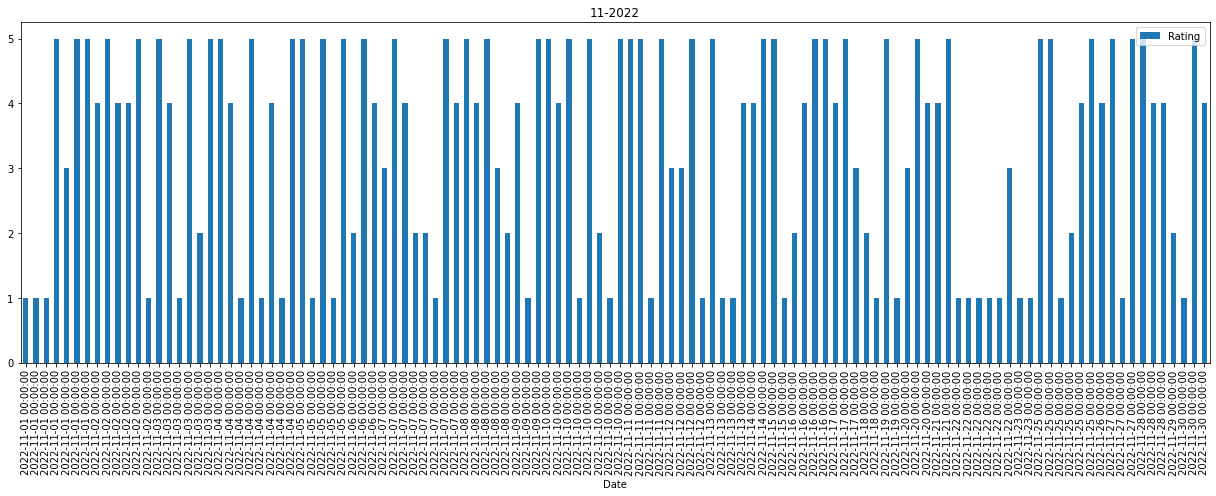

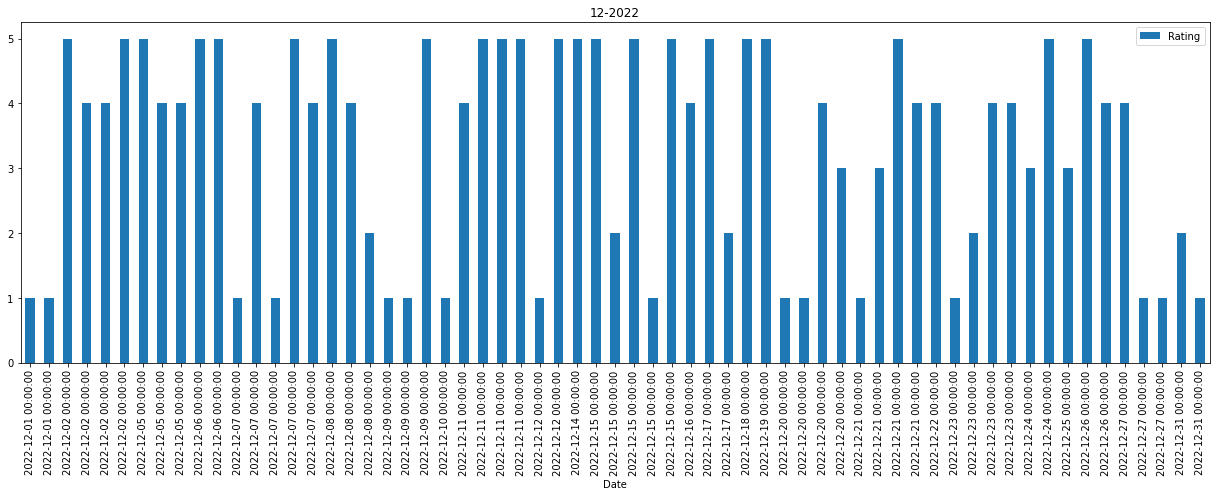

In [17]:
grouped = df2.groupby(['Month'])
for key, group in grouped:
    group.set_index('Date')[['Rating']].plot(kind = 'bar', title = key)

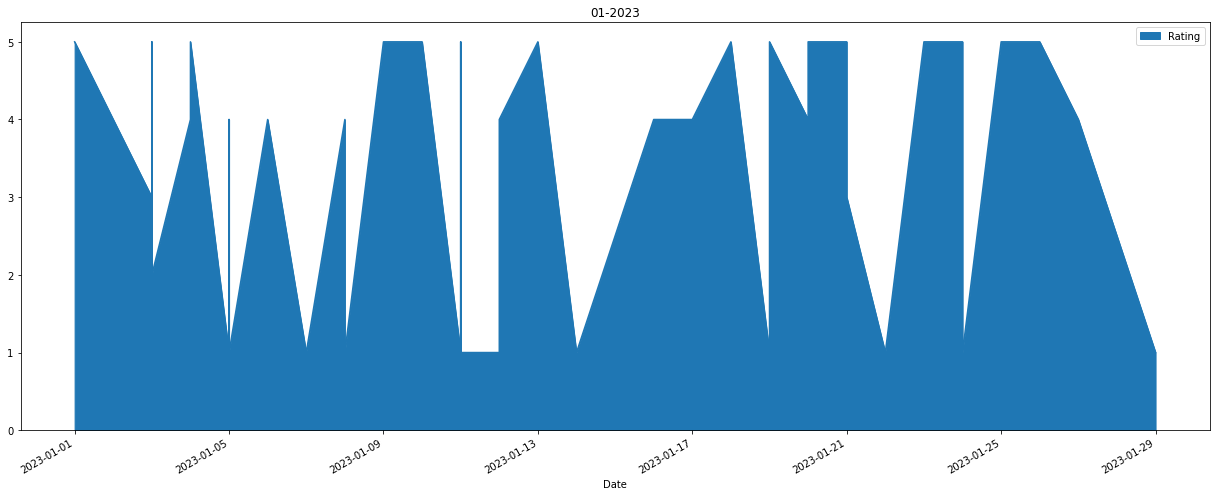

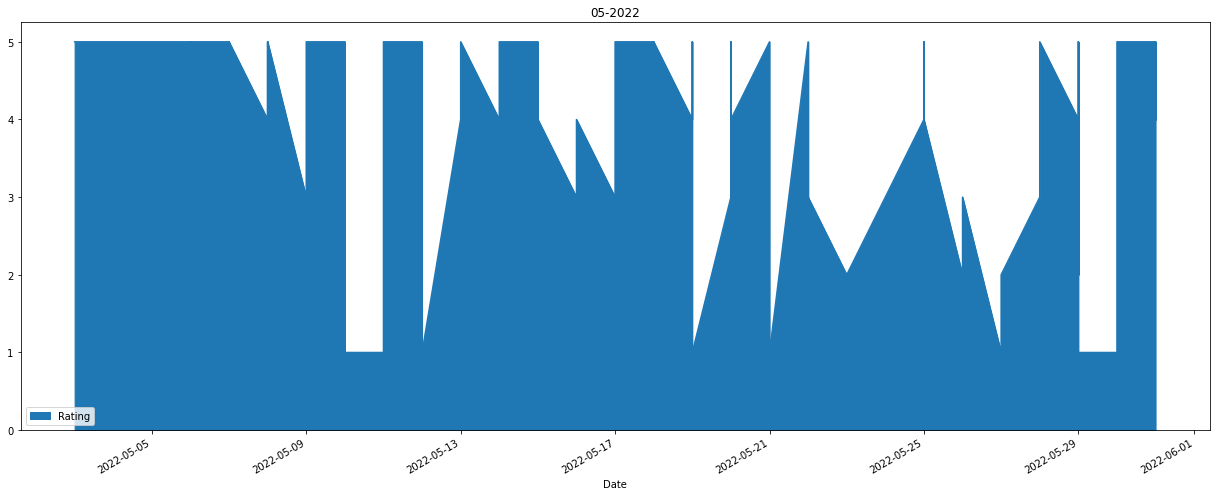

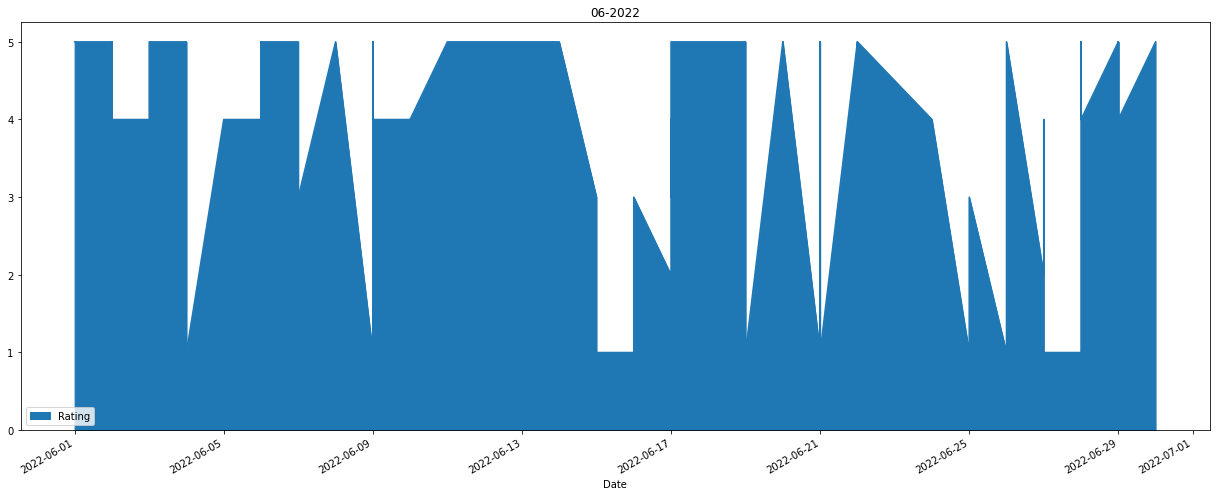

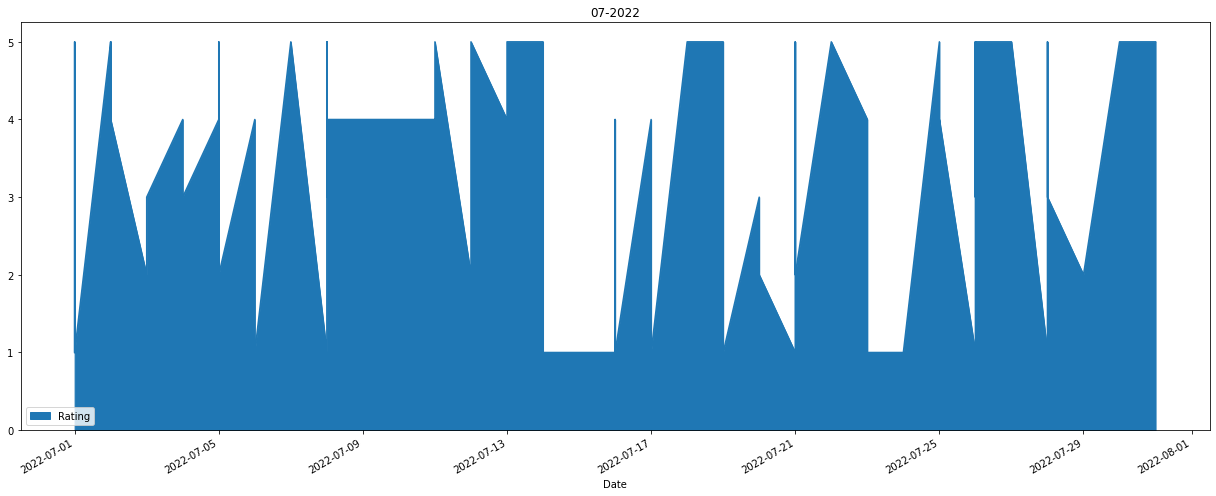

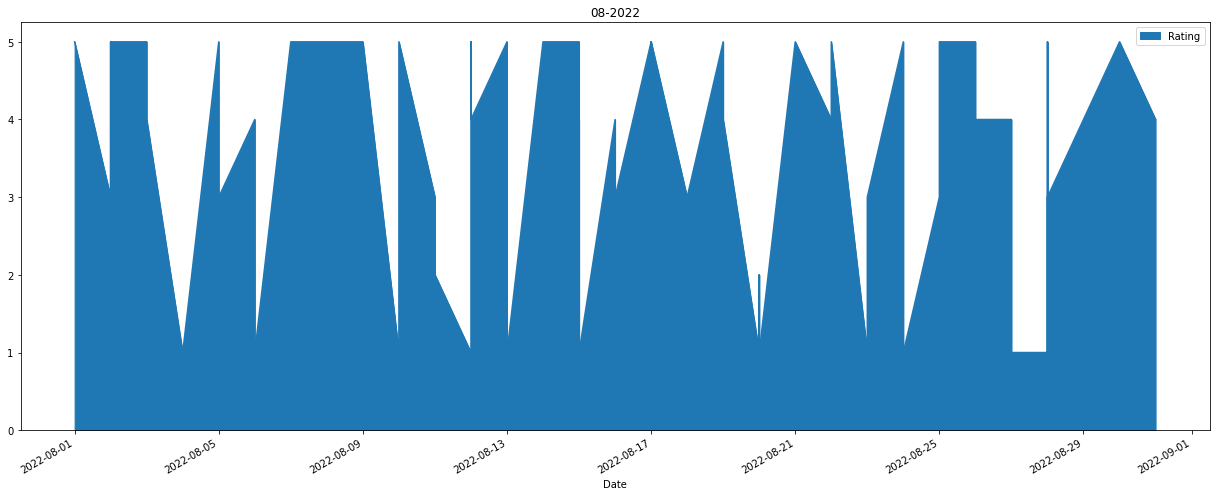

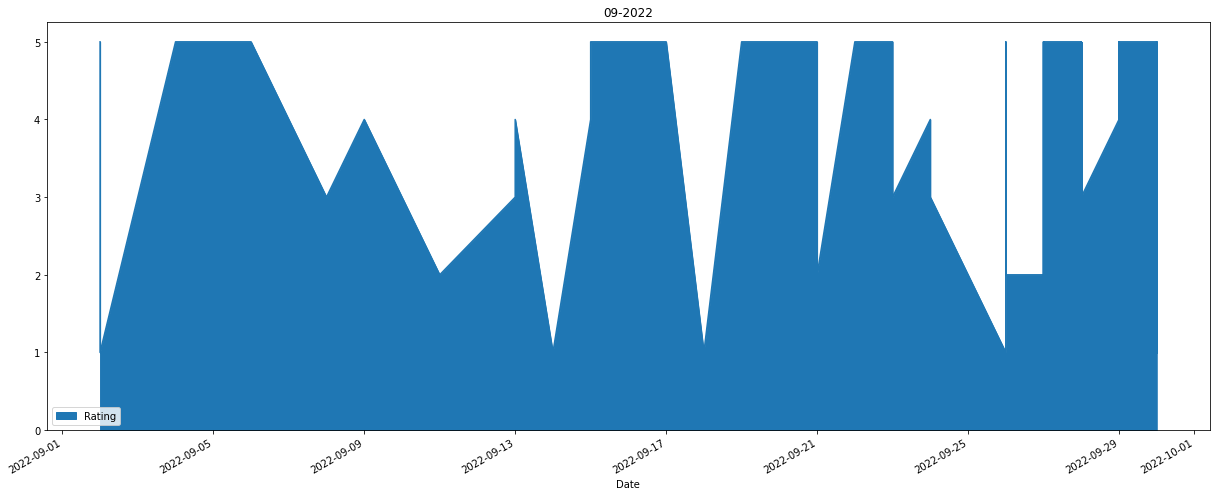

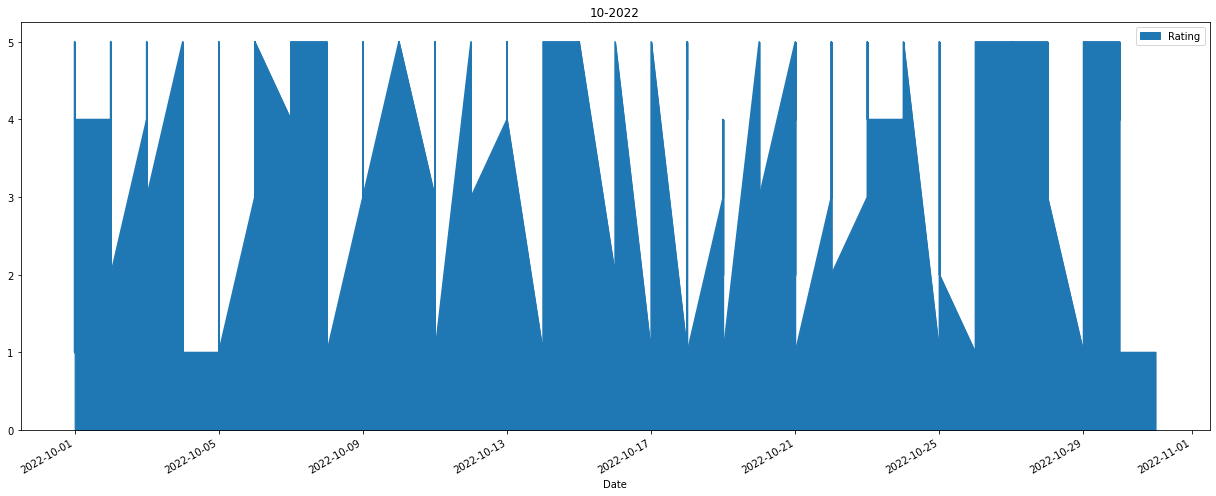

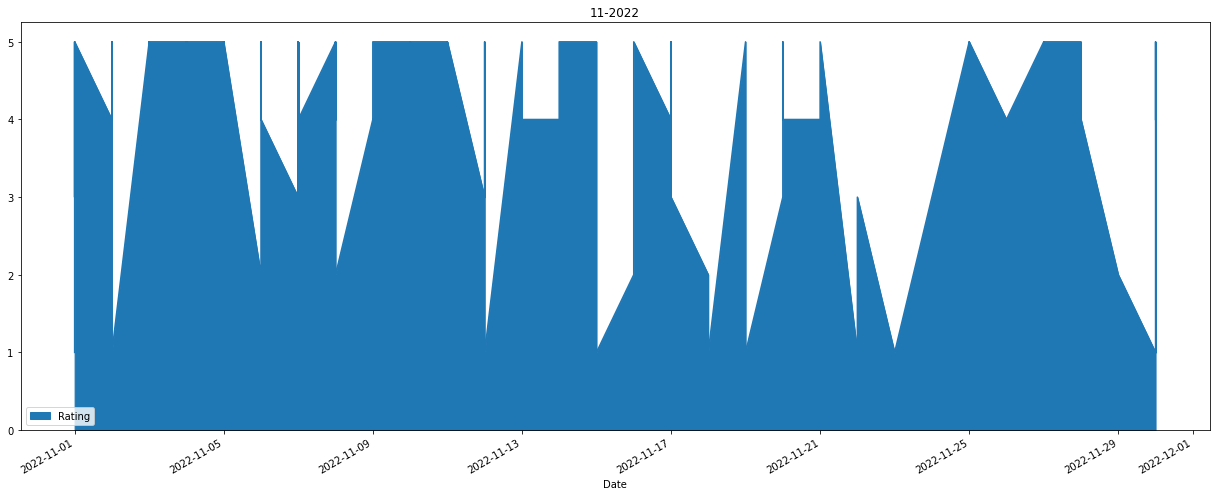

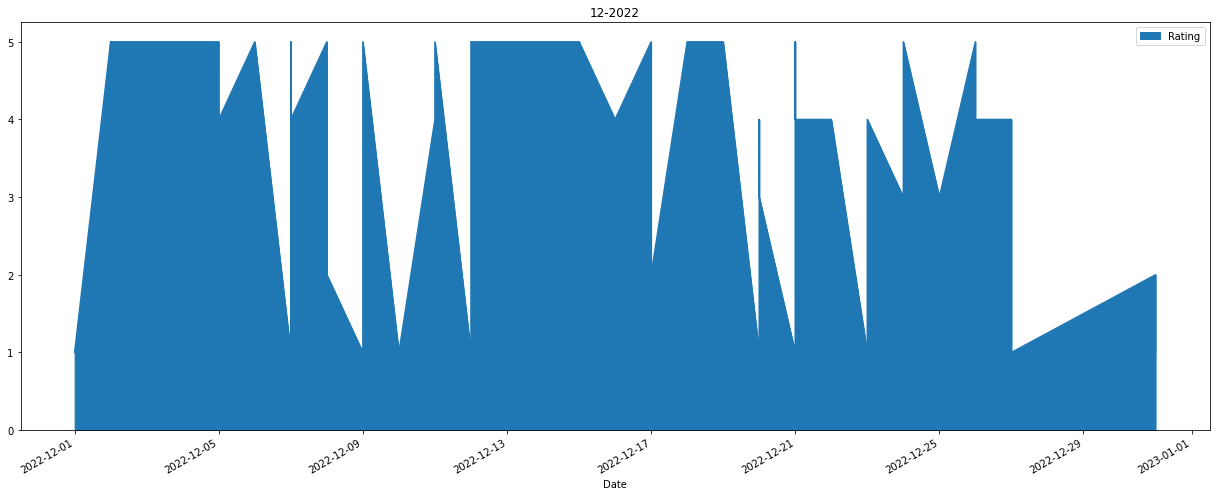

In [21]:
grouped = df2.groupby(['Month'])
for key, group in grouped:
    group.set_index('Date')[['Rating']].plot(kind = 'area', title = key)

In [36]:
grouped = df2.groupby(['Month'])
print(len(grouped))
for key, group in grouped:
    print("\nKEY     :   ", key)
    print("GROUP     :   \n", group)
#for key, group in grouped:
#    group.set_index('Date')[['Rating']].plot(kind = 'area', title = key)

9

KEY     :    01-2023
GROUP     :   
           Date  Rating    Month
204 2023-01-01     5.0  01-2023
601 2023-01-03     3.0  01-2023
677 2023-01-03     1.0  01-2023
95  2023-01-03     5.0  01-2023
871 2023-01-03     2.0  01-2023
18  2023-01-04     4.0  01-2023
117 2023-01-04     5.0  01-2023
252 2023-01-05     1.0  01-2023
10  2023-01-05     4.0  01-2023
909 2023-01-05     1.0  01-2023
391 2023-01-05     1.0  01-2023
23  2023-01-06     4.0  01-2023
17  2023-01-06     4.0  01-2023
463 2023-01-07     1.0  01-2023
16  2023-01-08     4.0  01-2023
605 2023-01-08     1.0  01-2023
92  2023-01-09     5.0  01-2023
135 2023-01-10     5.0  01-2023
410 2023-01-11     1.0  01-2023
198 2023-01-11     5.0  01-2023
121 2023-01-11     5.0  01-2023
498 2023-01-11     1.0  01-2023
563 2023-01-12     1.0  01-2023
11  2023-01-12     4.0  01-2023
122 2023-01-13     5.0  01-2023
634 2023-01-14     1.0  01-2023
3   2023-01-16     4.0  01-2023
5   2023-01-17     4.0  01-2023
139 2023-01-18     5.0  01-2023


In [24]:
df2.Date = pd.to_datetime(df2.Date)
df2.Month = pd.to_datetime(df2.Month)

In [ ]:
grouped = df2.groupby(['Month'])
print(len(grouped))
for key, group in grouped:
    print("\nKEY     :   ", key)
    print("GROUP     :   \n", group)
#for key, group in grouped:
#    group.set_index('Date')[['Rating']].plot(kind = 'area', title = key)

cubic_interpolation_model = interp1d(x, y, kind = "cubic")

# Plotting the Graph
X_=np.linspace(x.min(), x.max(), 500)
Y_=cubic_interpolation_model(X_)
 
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.interp1d Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()